# Events Table Stratified

__Description__: 
A stratified sampling of runoff events is performed on a runoff distribution derived from 
- Rainfall distribution based on the NOAA Atlas 14 (or mean precipitation curve) data (area averaged) and
- Max. potential retention distribution based on a beta distribution.

The rainfall distribution is assumed to be represented by a generalized extreme value distribution (GEV). This GEV distribution is fitted to the data (NOAA Atlas 14 data or corresponding values for the mean precipitation curve). The maximum potential distribution variabilitity corresponds to the curve number (CN) dispersion documented by the NRCS. For the rainfall distribution and runoff distribution, this notebook sequentially calculates 
- GEV distribution parameters for the NOAA or mean precipitation curve data
- Rainfall values and probability weights for different return period events
- Max potential retention variability and distribution parameters
- Partition for the max potential distribution for calculating the runoff distribution
- Runoff as a function of the return interval (i.e., return period)
- Runoff event probability weights
- A stratified sampling of runoff, where for each return interval the sampling includes
    - Event weight
    - Runoff value
    - Max. potential retention value
    - Rainfall value
    

__Input__: 
- Parameters: curve number and initial abstraction ratio; the probable maximum precipitation; return intervals for stratified sampling; maximum return interval limit for the stratified sampling bins;  the volume, region, and duration ([See map for volume and region](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html)).
        
- The area averaged precipitation frequency data for the specified duration.

- `DataRepository` folder which contains the following:
    - The *NEH630_Table_10_1.json* which contains information about the spread of possible values around the provided (expected) curve number. [Source](https://www.wcc.nrcs.usda.gov/ftpref/wntsc/H&H/NEHhydrology/ch10.pdf).


__Output__: 1 JSON file with the Hydro 1-4 event hyetographs and 1 JSON file with event weights. Additionally 4 DSS files with the Hydro 1-4 hyetograph information is prepared. Intermediate csv and excel files are saved for reference.


---
## Load Libraries, Parameters, and Data:
### Libraries:

In [1]:
import sys
sys.path.append('../../core')
from hydromet import*
from hydromet_stratified import*
import hydromet_JSON_to_DSS
import mean_frequency_curve
%matplotlib inline

### Parameters: 
#### Local (site specific):

In [2]:
## Excess rainfall parameters:
CN  = 85  # Curve number, must be an integer
mu  = 0.2  # Intial abstraction ratio parameter
PMP = 34.33  # [inches]; Probable maximum precipitation for the selected duration 
Return_Intervals = np.array([2, 5, 10, 25, 50, 100, 200, 500, 1000, 2000, 3000])  # Return intervals for calculating runoff values.
RI_upper_bound = 3700  # Upper Limit of recurrence interval evaluation, suggest not changing this value
lower_limit = 1 # Lower limit of NOAA Atlas 14 precipitation values
Aerial_Reduction = 1  # Aerial reduction factor
duration = 12  # [hours]; Event duration;  must be a duration in the input Precip_Table file
Time_Extend = 12.0 # Model run time extension beyond the hyetograph (24-hour) period.
hydrology_IDs = [1, 2, 3, 4]  # ID's of the different hydrology scenarios considered. 


## Mean curve parameters:
return_intervals_mc = np.array([1.01, 1.05, 1.11, 1.25, 20, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 1/2E-06, 1/1E-06, 1/5E-07, 1/2E-07, 1/1E-07]) # Additional return intervals for the mean curve inputs
CL = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.995, 0.999]) # Confidence limits

## Integration parameter:
n_partition = 30  # Define number of partitions of max potential retention distribution; this controls the resolution of the integration of int p(Q|S)p(S) dS

## Filenames and paths:
Project_Area = 'JoCo'          # Project area name
Pluvial_Model = 'P01'                # Pluvial model name
BCN = 'TurkeyCreek'               # Domain/boundary condition name 071200040505 Kansas 102500170609 Nevada '160600140303'

precip_table = '{0}_{1}_{2}_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)  # NOAA Data
precip_mean_curve_input_table = f'Mean_Curve_Input_{Project_Area}.csv'
precip_mean_curve_table = f'MeanCurve_{Project_Area}.csv'
CN_Distribution = 'NEH630_Table_10_1.json'
nrcs_precip_table = '{0}_{1}_{2}_nrcs_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)  # NRCS Data
atlas14_precip_table = '{0}_{1}_{2}_atlas_temporal_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)  # Atlas 14 Temporal Data

root_dir = pl.Path(os.getcwd())
outputs_dir = root_dir/'Outputs'
precip_table_dir = outputs_dir/precip_table
nrcs_precip_table_dir = outputs_dir/nrcs_precip_table   
atlas14_precip_table_dir = outputs_dir/atlas14_precip_table 
precip_mean_curve_input_table_dir = outputs_dir/precip_mean_curve_input_table
precip_mean_curve_table_dir = outputs_dir/precip_mean_curve_table
datarepository_dir = root_dir.parent.parent/'DataRepository'
bin_dir = root_dir.parent.parent/'bin'

## Options:
display_print = False

## Options:
save_dss = False
remove_ind_dur = True                              # Remove individual duration files which are combined at the end of this notebook
run_dur_dic = {'12': 1, '12': 1, '12': 1, '12': 1}  # Run durations in days

##### Convert all paths to objects:

In [3]:
outputs_dir = pl.Path(outputs_dir)
precip_table_dir = pl.Path(precip_table_dir)
precip_mean_curve_input_table_dir = pl.Path(precip_mean_curve_input_table_dir)
precip_mean_curve_table_dir = pl.Path(precip_mean_curve_table_dir)
datarepository_dir = pl.Path(datarepository_dir)

### Data:
#### NOAA Atlas 14 precipitation values:

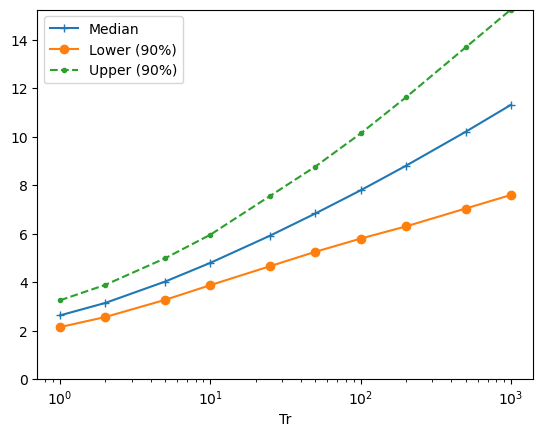

,Median,Lower (90%),Upper (90%)
Tr,,,
1,2.630202,2.146298,3.252532
2,3.142936,2.561979,3.888394


In [4]:
raw_precip = get_input_data(precip_table_dir, duration, lower_limit, display_print)
raw_precip.rename(columns = {'Expected Value': 'Median'}, inplace = True)
raw_precip.plot(style=['+-','o-','.--'], logx=True, ylim=(0, raw_precip['Upper (90%)'].max()))
plt.show()
raw_precip.head(2)

#### Fit GEV to rainfall data (find GEV parameters):

In [5]:
## Reduce precipitation by aerial reduction factor:
raw_precip_reduced = raw_precip[raw_precip.select_dtypes(include=['number']).columns]*Aerial_Reduction

## Find GEV parameter values:
df_GEV_parameters_M = GEV_parameters_Fit(raw_precip_reduced, 'Median', PMP)
df_GEV_parameters_U = GEV_parameters_Fit(raw_precip_reduced, 'Upper (90%)', PMP)
df_GEV_parameters_L = GEV_parameters_Fit(raw_precip_reduced, 'Lower (90%)', PMP)
df_GEV_parameters = pd.concat([df_GEV_parameters_M, df_GEV_parameters_L, df_GEV_parameters_U], axis=1)
df_GEV_parameters

C:\Users\dneupane\Documents\pfra-try\notebooks\pluvial\../../core\hydromet_stratified.py:62: RuntimeWarning:

divide by zero encountered in scalar divide



,GEV Median,GEV Lower (90%),GEV Upper (90%)
mu,2.807818,2.436809,3.690212
sigma,0.642746,0.640788,0.877558
xi,-0.232467,-0.046953,-0.180223


In [6]:
raw_precip_reduced

,Median,Lower (90%),Upper (90%)
Tr,,,
1,2.630202,2.146298,3.252532
2,3.142936,2.561979,3.888394
5,4.024649,3.270277,4.986479
10,4.796957,3.877011,5.957798
25,5.920426,4.660915,7.559415
50,6.834468,5.253830,8.770957
100,7.790021,5.798085,10.136085
200,8.802117,6.300000,11.624670
500,10.205819,7.039649,13.688574


#### Plot fitted GEV distribution and NOAA data:

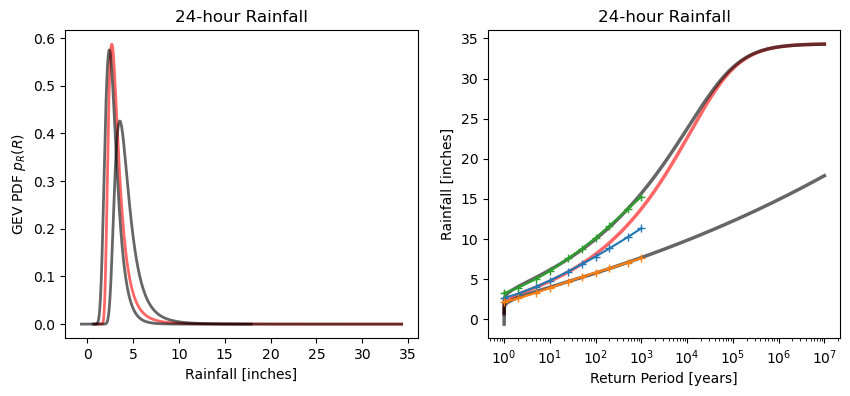

In [7]:
plot_GEV_precip_curves(raw_precip_reduced, df_GEV_parameters, PMP, 'Rainfall')
plt.show()

---
## Hydrology 1

In [8]:
Return_Intervals_Hydro1 = np.array([10, 25, 50, 100, 500])  # Hydrology 1 Return intervals for calculating runoff values.
GEV_parameters_M = df_GEV_parameters_M.values.transpose()[0]
df_weights_rainfall = weights_Rainfall(Return_Intervals_Hydro1, GEV_parameters_M, PMP, RI_upper_bound, raw_precip_reduced, 'Median', CN, mu)
df_weights_rainfall['Event Weight'].iloc[-2] = df_weights_rainfall['Event Weight'].iloc[-2]+df_weights_rainfall['Event Weight'].iloc[-1] # Add last event weight to the last event listed in the return intervals array
df_weights_rainfall = df_weights_rainfall[:-1].copy() # Drop the last event containing the rainfall amount of to the PMP
df_weights_rainfall

C:\Users\dneupane\AppData\Local\Temp\ipykernel_28636\1343539849.py:4: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




,Bin Floor,Bin Ceiling,Event Weight,Median,Runoff
10,6.746071,16.772096,0.088612,4.796957,3.180893
25,16.772096,42.240160,0.035949,5.920426,4.227507
50,42.240160,60.279103,0.007085,6.834468,5.094471
100,60.279103,206.737226,0.011752,7.790021,6.010807
500,206.737226,3700.000000,0.004837,10.205819,8.356230


#### Hydrology 1 Runoff Forcing Data:

In [9]:
#events and excess precip curves
prep_curves = precip_to_runoff_h1(Return_Intervals_Hydro1,nrcs_precip_table_dir,
                     raw_precip_reduced,df_weights_rainfall,CN)
final_curves = extend_time(prep_curves,Time_Extend,0.1)

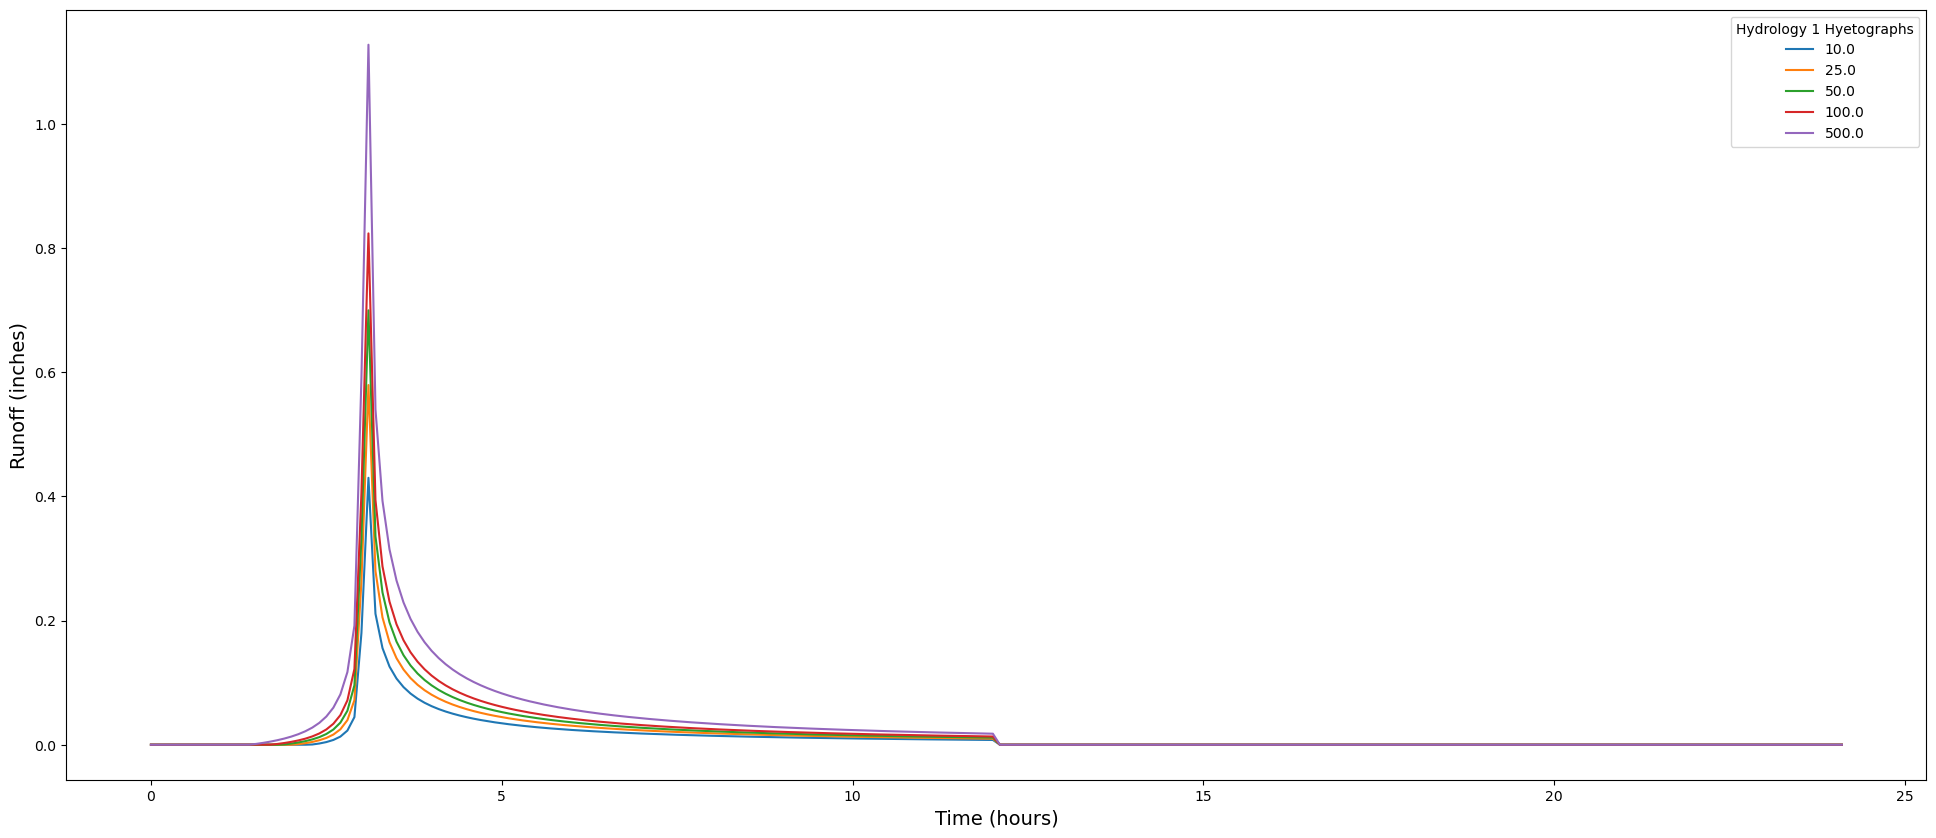

In [10]:
## test plot:
t_p = final_curves.plot(figsize=(24, 10))
t_p.legend(title='Hydrology 1 Hyetographs')
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Runoff (inches)', fontsize=14)
t_p.plot();
plt.show()

#### Hydrology 1 Weights:

In [11]:
#formatting
Event_Weights_Hydro = df_weights_rainfall['Event Weight'].apply(lambda x: '%.20f' % x).to_dict()

ID_Hydrology = 1
rename_map = Rename_Final_Events_Precip_Stratified(Event_Weights_Hydro, ID_Hydrology) 
renamed_weights = {}

for k, v in rename_map.items():
    renamed_weights[v] = Event_Weights_Hydro [k]

renamed_weights

{'E1001': '0.08861160016786841231',
 'E1002': '0.03594868865728952784',
 'E1003': '0.00708465576487021798',
 'E1004': '0.01175243886062885684',
 'E1005': '0.00483705823323439619'}

In [12]:
renamed_curves = final_curves.rename(columns=rename_map).copy()
renamed_curves.index = renamed_curves.index.to_series().apply(lambda x: '%.1f' % x)
renamed_curves.head(10)

,E1001,E1002,E1003,E1004,E1005
hours,,,,,
0.0,0.0,0.0,0.0,0.0,0.0
0.1,0.0,0.0,0.0,0.0,0.0
0.2,0.0,0.0,0.0,0.0,0.0
0.3,0.0,0.0,0.0,0.0,0.0
0.4,0.0,0.0,0.0,0.0,0.0
0.5,0.0,0.0,0.0,0.0,0.0
0.6,0.0,0.0,0.0,0.0,0.0
0.7,0.0,0.0,0.0,0.0,0.0
0.8,0.0,0.0,0.0,0.0,0.0


In [13]:
#convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight':list(renamed_weights.values())}, index = list(renamed_weights.keys())) 
df_renamed_weights 

,Weight
E1001,0.08861160016786841231
E1002,0.03594868865728952784
E1003,0.00708465576487021798
E1004,0.01175243886062885684
E1005,0.00483705823323439619


### Save Data

##### To CSV:

In [14]:
renamed_curves.to_csv(outputs_dir/'Excess_Rainfall_{0}_Dur{1}_Hydro{2}.csv'.format(BCN, duration,ID_Hydrology))
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_Hydro{2}.csv'.format(BCN, duration, ID_Hydrology))

In [15]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_Hydro{3}.xlsx'.format(Project_Area, Pluvial_Model, BCN, ID_Hydrology))

for i, d in enumerate(rename_map.keys()):
    table = renamed_curves[rename_map[d]]
    table.to_excel(writer, sheet_name = 'ras_input_{0}-{1}'.format(d,rename_map[d]))
 
writer.close()

---
## Hydrology 2

### Mean Curve Calculation
#### Data for calculating the mean curve:

In [9]:
return_interval_Data = return_interval_data(raw_precip_reduced, return_intervals_mc, df_GEV_parameters, PMP)
return_interval_Data

,Median,Lower (90%),Upper (90%),Log SD (Lower),Log SD (Upper),Max Log SD,mu LN
1.00,2.630202,2.146298,3.252532,0.123597,0.129102,0.129102,0.967061
1.01,1.980584,1.491184,2.517197,0.172536,0.145747,0.172536,0.683392
1.05,2.177323,1.741717,2.804964,0.135699,0.153978,0.153978,0.778096
1.11,2.318433,1.910283,3.007686,0.117714,0.158225,0.158225,0.840891
1.25,2.518250,2.135249,3.289994,0.100292,0.162506,0.162506,0.923564
2.00,3.142936,2.561979,3.888394,0.124242,0.129385,0.129385,1.145157
5.00,4.024649,3.270277,4.986479,0.126178,0.130269,0.130269,1.392438
10.00,4.796957,3.877011,5.957798,0.129433,0.131744,0.131744,1.567982
20.00,5.557446,4.479180,7.136977,0.131124,0.152067,0.152067,1.715139
25.00,5.920426,4.660915,7.559415,0.145408,0.148563,0.148563,1.778408


#### Input for calculating the mean curve:

In [10]:
mean_curve_data = mean_curve_input_table(CL, return_interval_Data, PMP, precip_mean_curve_input_table_dir)
mean_curve_data

,0.001,0.005,0.010,0.050,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900,0.950,0.990,0.995,0.999
AEP,,,,,,,,,,,,,,,,,
1.000000e-07,25.661950,27.408171,28.206254,30.175716,31.077471,32.013701,32.578006,32.986079,33.307096,33.572345,33.798714,33.996380,34.171958,34.252943,34.314884,34.322460,34.328495
2.000000e-07,24.503877,26.437369,27.329000,29.550194,30.576961,31.649357,32.298843,32.769958,33.141416,33.448906,33.711724,33.941518,34.145870,34.240201,34.312381,34.321211,34.328246
5.000000e-07,22.946425,25.112118,26.123461,28.676736,29.873061,31.133205,31.901639,32.461492,32.904366,33.271937,33.586798,33.862614,34.108300,34.221840,34.308773,34.319411,34.327886
1.000000e-06,21.784593,24.107888,25.203528,27.998862,29.322628,30.726443,31.587164,32.216459,32.715573,33.130691,33.486907,33.799422,34.078168,34.207104,34.305876,34.317965,34.327597
2.000000e-06,20.686596,23.145594,24.316511,27.335306,28.780147,30.322743,31.273746,31.971512,32.526397,32.988883,33.386451,33.735781,34.047783,34.192236,34.302951,34.316506,34.327306
5.000000e-06,19.454594,22.048617,23.298095,26.560049,28.141310,29.843435,30.899797,31.678218,32.299252,32.818220,33.265318,33.658908,34.011025,34.174236,34.299409,34.314738,34.326953
1.000000e-05,15.046263,17.875246,19.311299,23.297370,25.359292,27.678993,29.173026,30.301555,31.219117,31.997828,32.677565,33.282844,33.829883,34.085234,34.281846,34.305972,34.325202
2.000000e-05,10.331177,12.932832,14.346195,18.637071,21.095744,24.087267,26.155497,27.799065,29.191073,30.414196,31.514991,32.522524,33.456275,33.899940,34.245018,34.287572,34.321524
5.000000e-05,6.832740,8.804217,9.930996,13.638931,15.999211,19.168370,21.596956,23.698518,25.620911,27.437266,29.190835,30.910577,32.617892,33.472375,34.158136,34.244044,34.312805


##### Calculate the mean precipitation curve:

Specified inputs_path is to a csv, loaded table.



C:\Users\dneupane\Documents\pfra-try\notebooks\pluvial\../../core\meanffc.py:173: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


C:\Users\dneupane\Documents\pfra-try\notebooks\pluvial\../../core\meanffc.py:176: UserWarning:

Values not increa

,P_Mean_in,P_Median_in
AEP,,
0.9,2.200819,2.320652
0.5,3.189272,3.142936


C:\Users\dneupane\Documents\pfra-try\notebooks\pluvial\Outputs - already exists



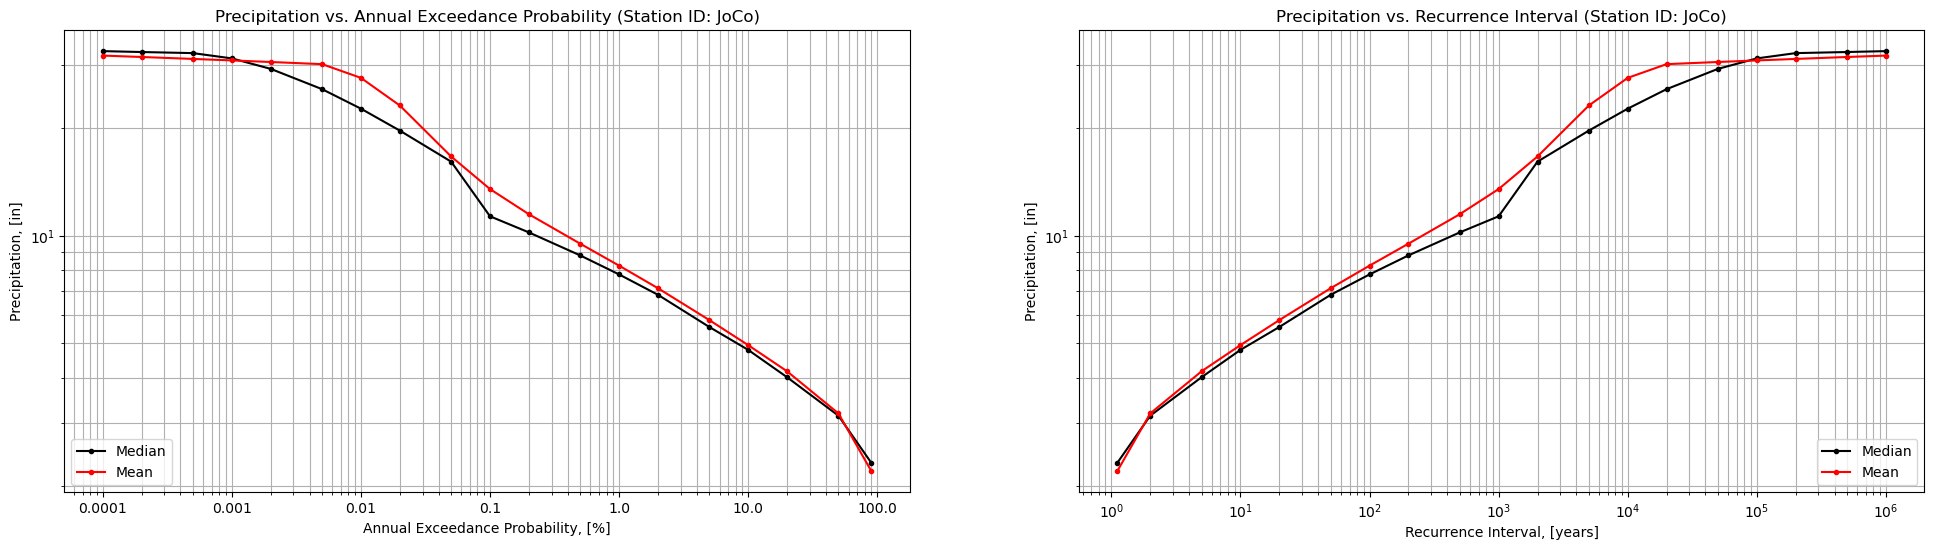

In [11]:
df = mean_frequency_curve.main(Project_Area, precip_mean_curve_input_table_dir, outputs_dir, data_type = 'P', round_decimals = 6)
plt.show()

In [12]:
df

,P_Mean_in,P_Median_in
AEP,,
0.900000,2.200819,2.320652
0.500000,3.189272,3.142936
0.200000,4.180794,4.024649
0.100000,4.946273,4.796957
0.050000,5.809515,5.557446
0.020000,7.129490,6.834468
0.010000,8.242454,7.790021
0.005000,9.490849,8.802117
0.002000,11.470975,10.205819


---
### Load Mean Curve:

In [13]:
mean_curve_precip = pd.read_csv(precip_mean_curve_table_dir, index_col=0)
mean_curve_precip['Tr'] = 1.0/mean_curve_precip.index.values
mean_curve_precip.set_index('Tr', inplace = True)
mean_curve_precip.plot(style=['+-', 'o-'], logx=True, ylim=(0, PMP))
mean_curve_precip.head(2)

,P_Mean_in,P_Median_in
Tr,,
1.111111,2.200819,2.320652
2.000000,3.189272,3.142936


### Fit GEV to Mean Precipication Curve (Find GEV Parameters):

C:\Users\dneupane\AppData\Local\Temp\ipykernel_28636\980014200.py:1: FutureWarning:

The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead



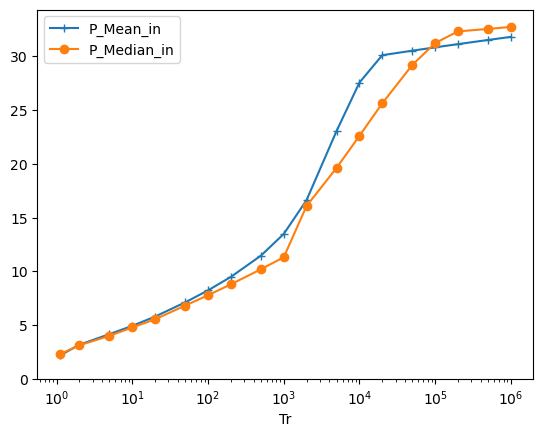

In [14]:
fit_values_mean_curve_precip = mean_curve_precip[1:20000] # Only fit the value up to about the 20,000 year event
df_GEV_parameters_E = GEV_parameters_Fit(fit_values_mean_curve_precip, 'P_Mean_in', PMP)
GEV_parameters_E = df_GEV_parameters_E.values.transpose()[0]
df_GEV_parameters = pd.concat([df_GEV_parameters, df_GEV_parameters_E], axis=1)
df_GEV_parameters
plt.show()

#### Plot fitted GEV distribution and mean precipitation curve:

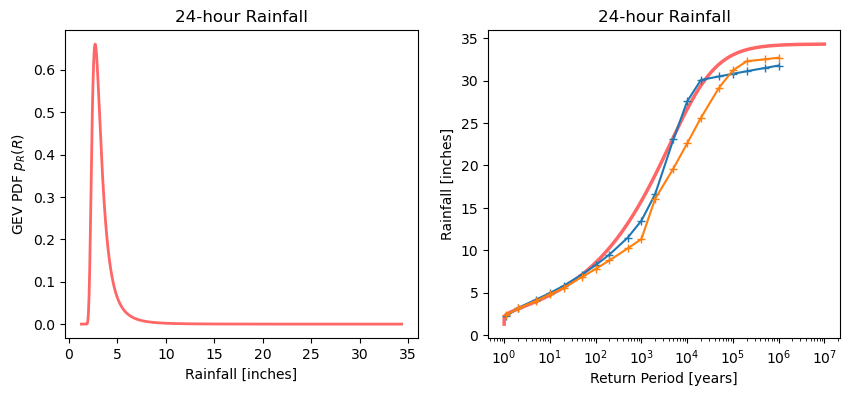

In [15]:
plot_GEV_precip_curves(mean_curve_precip, df_GEV_parameters_E, PMP, 'Rainfall')
plt.show()

### Hydrology 2 Events:

In [16]:
df_weights_rainfall = weights_Rainfall(Return_Intervals, GEV_parameters_E, PMP, RI_upper_bound, mean_curve_precip, 'P_Mean_in', CN, mu)
df_weights_rainfall.head(2)

,Bin Floor,Bin Ceiling,Event Weight,P_Mean_in,Runoff
2.0,1.245372,4.118170,0.560147,3.189272,1.748470
5.0,4.118170,6.225986,0.082209,4.180794,2.619992


#### Hydrology 2 Runoff Forcing Data:

In [27]:
#events and excess precip curves
hydro_events = df_weights_rainfall.index.to_numpy().tolist()
prep_curves = precip_to_runoff_h2(hydro_events,nrcs_precip_table_dir,df_weights_rainfall,df_weights_rainfall,CN)
final_curves = extend_time(prep_curves,Time_Extend,0.1)

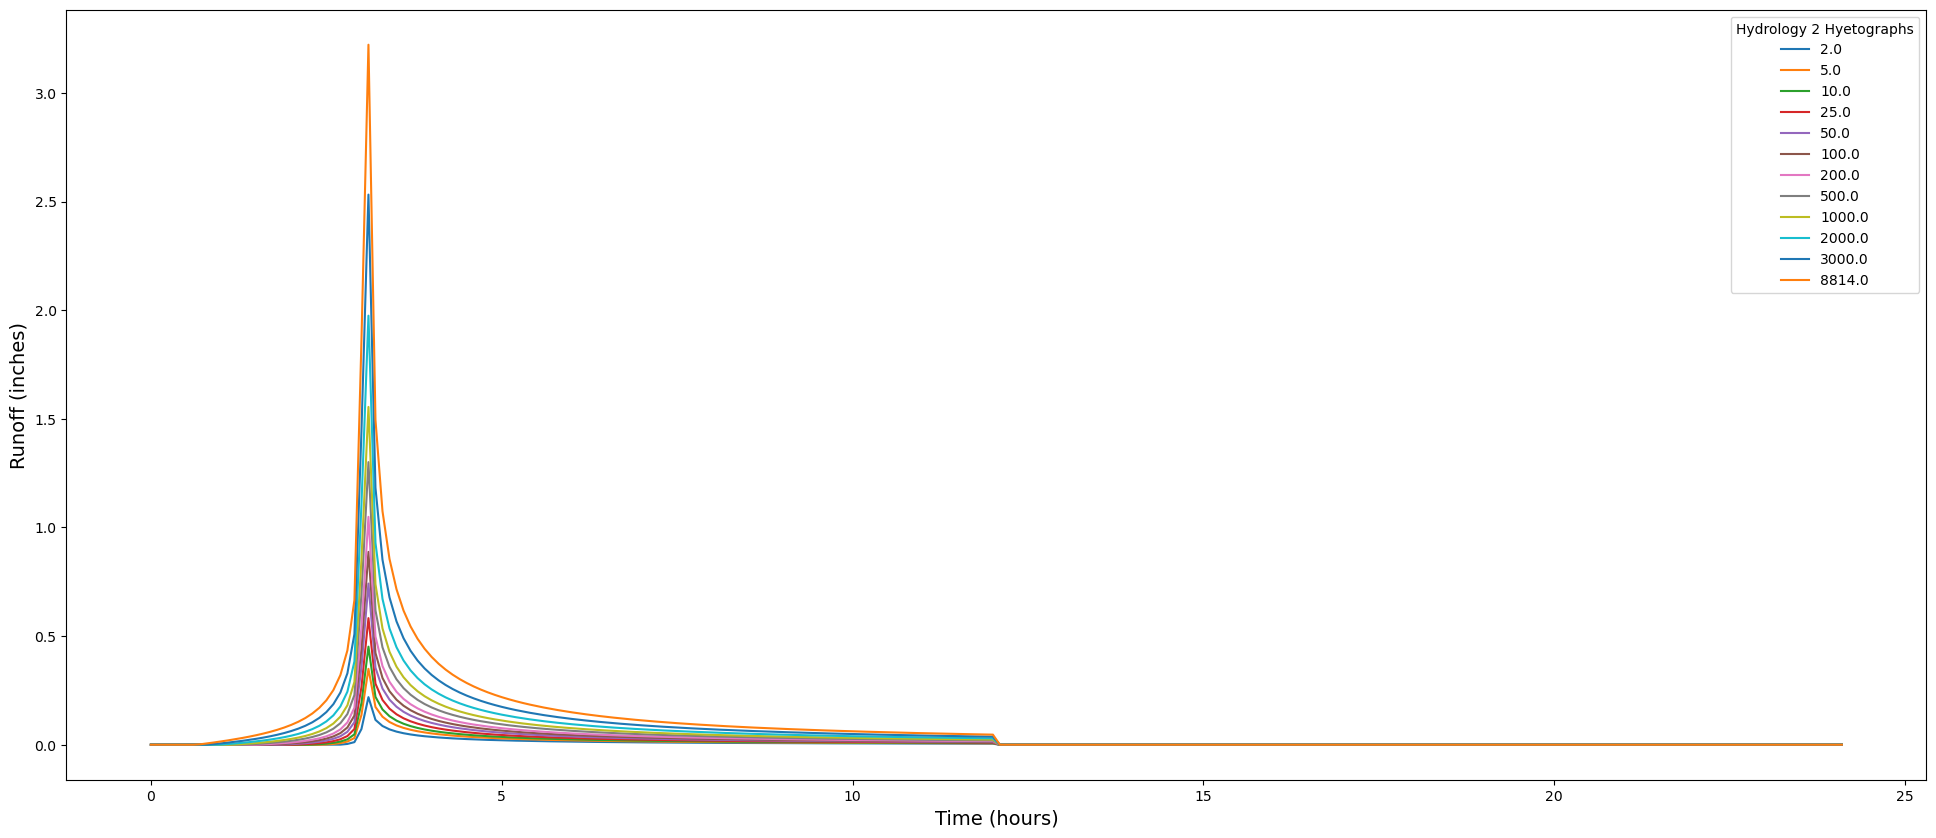

In [29]:
#graph
t_p = final_curves.plot(figsize=(24, 10))
t_p.legend(title='Hydrology 2 Hyetographs')
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Runoff (inches)', fontsize=14)
t_p.plot();
plt.show()

#### Hydrology 2 Weights:

In [111]:
#formatting
Event_Weights_Hydro = df_weights_rainfall['Event Weight'].apply(lambda x: '%.20f' % x).to_dict()

ID_Hydrology = 2
rename_map = Rename_Final_Events_Precip_Stratified(Event_Weights_Hydro, ID_Hydrology) #set naming convention
renamed_weights = {}

for k, v in rename_map.items():
    renamed_weights[v] = Event_Weights_Hydro[k]

renamed_weights

{'E2001': '0.56014683476793747374',
 'E2002': '0.08220914898969519657',
 'E2003': '0.10874295320181640023',
 'E2004': '0.02239765745036223499',
 'E2005': '0.01733170497461306719',
 'E2006': '0.00410854231501703478',
 'E2007': '0.00543778618062317615',
 'E2008': '0.00113019624706066205',
 'E2009': '0.00086135026299822019',
 'E2010': '0.00020594667455880946',
 'E2011': '0.00013073105624718289',
 'E2012': '0.00027027027027027027'}

In [112]:
renamed_curves = final_curves.rename(columns=rename_map).copy()
renamed_curves.index = renamed_curves.index.to_series().apply(lambda x: '%.1f' % x)
renamed_curves.head(10)

,E2001,E2002,E2003,E2004,E2005,E2006,E2007,E2008,E2009,E2010,E2011,E2012
hours,,,,,,,,,,,,
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
0.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.001851
0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000396,0.006057


In [113]:
#convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight':list(renamed_weights.values())}, index = list(renamed_weights.keys())) 
df_renamed_weights 

,Weight
E2001,0.56014683476793747374
E2002,0.08220914898969519657
E2003,0.10874295320181640023
E2004,0.02239765745036223499
E2005,0.01733170497461306719
E2006,0.00410854231501703478
E2007,0.00543778618062317615
E2008,0.00113019624706066205
E2009,0.00086135026299822019
E2010,0.00020594667455880946


### Save

##### To CSV:

In [114]:
renamed_curves.to_csv(outputs_dir/'Excess_Rainfall_{0}_Dur{1}_Hydro{2}.csv'.format(BCN, duration,ID_Hydrology))
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_Hydro{2}.csv'.format(BCN, duration, ID_Hydrology))

In [115]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_Hydro{3}.xlsx'.format(Project_Area, Pluvial_Model, BCN, ID_Hydrology))

for i, d in enumerate(rename_map.keys()):
    table = renamed_curves[rename_map[d]]
    table.to_excel(writer, sheet_name = 'ras_input_{0}-{1}'.format(d,rename_map[d]))
 
writer.close()

---
## Hydrology 3:
### Retrieve Max Potential Retention Variability and Distribution Parameters:

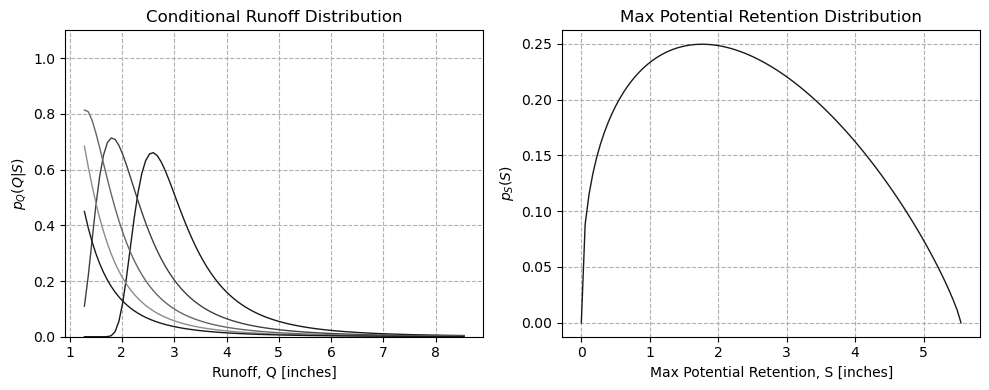

In [17]:
## NRCS value of wet and dry soil moiture conditions:
arc_data = get_CN_distribution(datarepository_dir, CN_Distribution, CN, display_print)

## Table of wet, dry, and average (or median) soil moisture conditions:
df_CN = prep_cn_table(CN, arc_data)  

## Table of parameters for best fit of beta-type distribution to NRCS estiamted dispersion:
fitted_cn = find_optimal_curve_beta_dist_S(df_CN)
fitted_cn['mu'] = mu

## Distribution parameter values:
S_limit = 1000.0/fitted_cn.iloc[0]['CN Lower Limit']-10.0
alpha = fitted_cn.iloc[0]['alpha']
beta = fitted_cn.iloc[0]['beta']

## Define probability for each partition of the max potential retention distribution:
Delta_P = 1.0/n_partition

## Find the average value over each partition, which is the basis for the runoff distribution:
partition_avg = partition_S_avgs(n_partition, Delta_P, alpha, beta, S_limit)

plot_runoff_maxRetention_distributions(GEV_parameters_E, PMP, fitted_cn)
plt.show()

In [31]:
df_CN

,AMC I (Dry),AMC II,AMC III (Wet)
1,70,85,94


In [32]:
fitted_cn

,AMC I (Dry),AMC II,AMC III (Wet),alpha,beta,CN Lower Limit,Fitted AMC I (Dry),Fitted AMC II,Fitted AMC III (Wet),mu
1,70,85,94,1.392002,1.840343,64.320629,70.000046,85.001444,93.998659,0.2


In [33]:
S_limit, alpha, beta

(5.547111716274683, 1.3920022969662778, 1.8403429081660123)

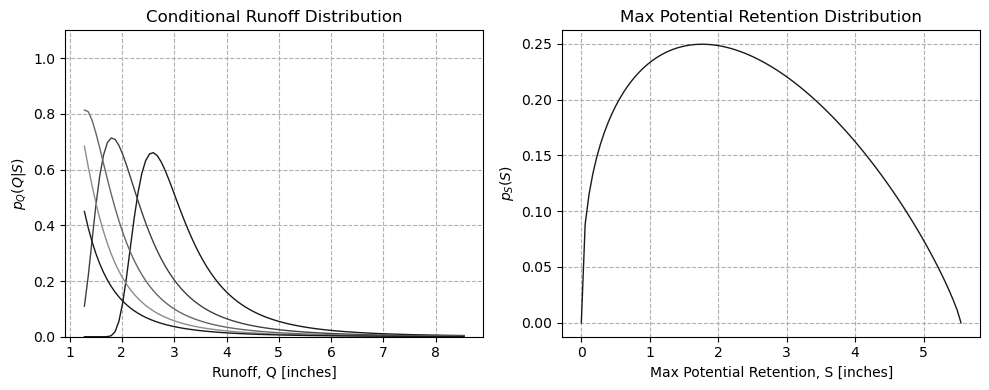

In [24]:
custom_cycler = cycler('color', ['0.1', '0.25', '0.4', '0.55']) + cycler('lw', [1, 1, 1, 1])
S_limit = 1000.0/fitted_cn.iloc[0]['CN Lower Limit']-10.0
alpha = fitted_cn.iloc[0]['alpha']
beta = fitted_cn.iloc[0]['beta']
mu = fitted_cn.iloc[0]['mu']

_, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].set_prop_cycle(custom_cycler)

Q = np.linspace(PPF_GEV(1e-100, GEV_parameters_E, PMP), PPF_GEV(0.99, GEV_parameters_E, PMP), 100)
SA = np.linspace(0.1, 3.5, 5)
ax[0].plot(Q, np.transpose([PDF_QlS(Q, S1, mu, GEV_parameters_E, PMP) for S1 in SA]))

ax[0].grid(linestyle='--')
ax[0].set_ylim((0, 1.1))
ax[0].set_xlabel('Runoff, Q [inches]')
ax[0].set_ylabel('$p_Q(Q | S)$') 
ax[0].set_title('Conditional Runoff Distribution')
ax[1].set_prop_cycle(custom_cycler)

S = np.linspace(0.0, S_limit, 100)
ax[1].plot(S, (1.0/S_limit)*stats.beta(alpha, beta).pdf(S/S_limit))

ax[1].grid(linestyle='--')
ax[1].set_xlabel('Max Potential Retention, S [inches]')
ax[1].set_ylabel('$p_S(S)$') 
ax[1].set_title('Max Potential Retention Distribution')
plt.tight_layout()
plt.show()

#### Calculate the error in the numerical CDF evaluated at PMP:

In [27]:
## Error between the integral approach (based on summation integration) and the actual value:
error_PQ = 1-CDF_Q(PMP, mu, alpha, beta, S_limit, GEV_parameters_E, PMP, partition_avg, Delta_P, 0)

print('\nProbability of zero runoff = {}\nError in calculation of Probabilibity of zero runoff = {}\n'
      'Error, i.e., the difference between 1 and the numerical CDF evaluated at PMP, Error = {}'
      ''.format(P_Qzero(mu, alpha, beta, S_limit, GEV_parameters_E, PMP, error_PQ)[0], P_Qzero(mu, alpha, beta, S_limit, GEV_parameters_E, PMP, error_PQ)[1], error_PQ))


Probability of zero runoff = 0.0
Error in calculation of Probabilibity of zero runoff = 0.0
Error, i.e., the difference between 1 and the numerical CDF evaluated at PMP, Error = -1.5592597546687514e-05


### Determine Runoff Values and Weights:
#### Fit GEV to runoff data (find GEV parameters):

In [28]:
df_runoff, df_GEV_parameters_R = runoff_GEV(mu, GEV_parameters_E, PMP, alpha, beta, S_limit, partition_avg, Delta_P, error_PQ)
GEV_parameters_R = df_GEV_parameters_R.values.transpose()[0]
df_GEV_parameters_R

C:\Users\dneupane\Documents\pfra-try\notebooks\pluvial\../../core\hydromet_stratified.py:62: RuntimeWarning:

divide by zero encountered in scalar divide



,GEV Runoff
mu,1.366284
sigma,0.529396
xi,-0.305161


In [66]:
Q_line = np.linspace(0.01, PMP - 0.01, 40+1)
Return_PeriodQ = 1.0/(1-np.transpose([CDF_Q(Q, mu, alpha, beta, S_limit, GEV_parameters_E, PMP, partition_avg, 
                                            Delta_P, error_PQ) for Q in Q_line]))
df_runoff = pd.DataFrame(Q_line, index=Return_PeriodQ, columns=['Runoff'])
df_GEV_parameters_R = GEV_parameters_Fit(df_runoff, 'Runoff', PMP)

C:\Users\dneupane\Documents\pfra-try\notebooks\pluvial\../../core\hydromet_stratified.py:62: RuntimeWarning:

divide by zero encountered in scalar divide



In [67]:
Q_line

array([1.000000e-02, 8.677500e-01, 1.725500e+00, 2.583250e+00,
       3.441000e+00, 4.298750e+00, 5.156500e+00, 6.014250e+00,
       6.872000e+00, 7.729750e+00, 8.587500e+00, 9.445250e+00,
       1.030300e+01, 1.116075e+01, 1.201850e+01, 1.287625e+01,
       1.373400e+01, 1.459175e+01, 1.544950e+01, 1.630725e+01,
       1.716500e+01, 1.802275e+01, 1.888050e+01, 1.973825e+01,
       2.059600e+01, 2.145375e+01, 2.231150e+01, 2.316925e+01,
       2.402700e+01, 2.488475e+01, 2.574250e+01, 2.660025e+01,
       2.745800e+01, 2.831575e+01, 2.917350e+01, 3.003125e+01,
       3.088900e+01, 3.174675e+01, 3.260450e+01, 3.346225e+01,
       3.432000e+01])

In [68]:
Return_PeriodQ

array([1.00000000e+00, 1.25453343e+00, 2.39315314e+00, 5.59443130e+00,
       1.29104291e+01, 2.57352470e+01, 4.54820315e+01, 7.36844616e+01,
       1.11983492e+02, 1.62134760e+02, 2.26026016e+02, 3.05701702e+02,
       4.03394742e+02, 5.21566659e+02, 6.62957813e+02, 8.30650289e+02,
       1.02814685e+03, 1.25947063e+03, 1.52929202e+03, 1.84309158e+03,
       2.20737147e+03, 2.62993330e+03, 3.12024786e+03, 3.68995478e+03,
       4.35354868e+03, 5.12933884e+03, 6.04081903e+03, 7.11866816e+03,
       8.40374939e+03, 9.95174251e+03, 1.18405515e+04, 1.41826433e+04,
       1.71466253e+04, 2.09972879e+04, 2.61756080e+04, 3.34745349e+04,
       4.44776851e+04, 6.28720307e+04, 9.96758232e+04, 2.09472586e+05,
       1.91744683e+07])

In [44]:
df_runoff.to_excel("df_runoff_Hydro3.xlsx")

In [48]:
df_runoff

,Runoff
1.000000e+00,0.01000
1.254533e+00,0.86775
2.393153e+00,1.72550
5.594431e+00,2.58325
1.291043e+01,3.44100
2.573525e+01,4.29875
4.548203e+01,5.15650
7.368446e+01,6.01425
1.119835e+02,6.87200
1.621348e+02,7.72975


#### Plot fitted rainfall and runoff GEV distributions:

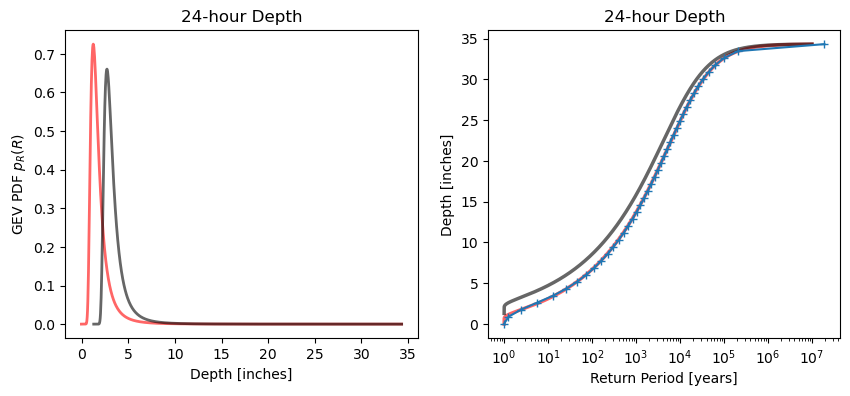

In [29]:
plot_GEV_precip_curves(df_runoff, pd.concat([df_GEV_parameters_R, df_GEV_parameters_E], axis=1), PMP, 'Depth')
plt.show()

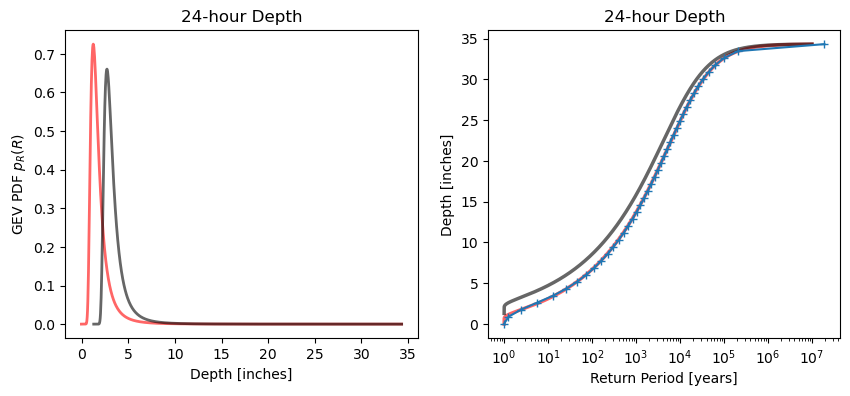

In [38]:
#def plot_GEV_precip_curves(precip_data: pd.DataFrame, df_GEV_parameters: pd.DataFrame, PMP: float, Label1: str='') -> None:
"""This functions plots the GEV distributions and also associated GEV return frequency curves on top of the 
   precpitation curve data taken either from NOAA Atlas 14 or from the mean precipitation curve output.
"""
df_GEV_parameters = pd.concat([df_GEV_parameters_R, df_GEV_parameters_E], axis=1)
color = ['r', 'k', 'k']
_, ax = plt.subplots(1, 2, figsize=(10,4))
for i, (_, columndata) in enumerate(df_GEV_parameters.items()):
    Precip = np.linspace(PPF_GEV(1e-100, columndata.values, PMP), PPF_GEV(0.9999999, columndata.values, PMP), 1000)
    Return_Period = 1.0/(1-CDF_GEV(Precip, columndata.values, PMP))
    
    ax[0].plot(Precip, PDF_GEV(Precip, columndata.values, PMP), color[i] , lw=2, alpha=0.6)
    ax[1].plot(Return_Period, Precip, color[i], lw=2.5, alpha=0.6)
    
for _, columndata in df_runoff.items():
    columndata.plot(style=['+-', 'o-', '.--'], logx=True)
    
ax[0].set_xlabel(f'Depth [inches]')
ax[0].set_ylabel('GEV PDF $p_R(R)$')
ax[0].set_title(f'24-hour Depth')
ax[1].set_xscale('log')
ax[1].set_xlabel('Return Period [years]')
ax[1].set_ylabel(f'Depth [inches]')
ax[1].set_title(f'24-hour Depth')  
plt.show()

#### Runoff weights:

In [39]:
df_weights_runoff = runoff_weights(Return_Intervals, RI_upper_bound, mu, GEV_parameters_R,  GEV_parameters_E, PMP, partition_avg, Delta_P, error_PQ)
df_weights_runoff.head(2)

,Bin Floor,Bin Ceiling,Event Weight,Runoff
2,1.243898,4.119967,0.561204,1.571534
5,4.119967,6.220538,0.081963,2.373086


In [69]:
df_weights_runoff

,Bin Floor,Bin Ceiling,Event Weight,Runoff
2,1.243898,4.119967,0.561204,1.571534
5,4.119967,6.220538,0.081963,2.373086
10,6.220538,19.285480,0.108905,3.078335
25,19.285480,33.892991,0.022348,4.233783
50,33.892991,82.403766,0.017369,5.333347
100,82.403766,124.292811,0.004090,6.681513
200,124.292811,384.961487,0.005448,8.334513
500,384.961487,680.338394,0.001128,11.091334
1000,680.338394,1646.597548,0.000863,13.680225
2000,1646.597548,2493.087316,0.000206,16.725867


In [70]:
(1/1.243898)-(1/4.119967)

0.5612040468126912

In [40]:
Size = Return_Intervals.size

# To find bin ceilings and floors
Bin_Bounds = np.zeros(Size+1)
Bin_Bounds[Size] = RI_upper_bound
for i in range(0, Size):
    Bin_Bounds[Size-i-1] = bound_lower_GEV(Bin_Bounds[Size-i], Return_Intervals[Size-i-1], GEV_parameters_R, 
                                           np.array([Return_Intervals[Size-i-1]*0.2]), PMP).x[0] 
#To find the average RI of 12th event. 
lower_bound = GEV_RI(RI_upper_bound, GEV_parameters_R, PMP)
Avg_Plus = Avg_Q(lower_bound, PMP, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, 
                 error_PQ)[0]/(1.0/RI_upper_bound)
Prob_Plus = CDF_GEV(Avg_Plus, GEV_parameters_R, PMP)
RI_index = np.append(Return_Intervals, 1.0/(1.0-Prob_Plus)).astype(int)  # 1-Prob_Plus is done because Prob_Plus is cdf till PMP and we are looking for RI-index above PMP

Event_Amount = GEV_RI(RI_index, GEV_parameters_R, PMP)
df_runoff = pd.DataFrame(data=Event_Amount, index=RI_index.astype(int), columns=['Runoff'])
weights = (1.0/Bin_Bounds[:-1]-1.0/Bin_Bounds[1:]).astype(float) 
weights = np.append(weights, 1/RI_upper_bound)
data = np.vstack((Bin_Bounds, np.append(Bin_Bounds[1:], np.inf), weights)).T
df_weights = pd.DataFrame(data=data, index=RI_index.astype(int), columns=['Bin Floor', 'Bin Ceiling', 
                                                                          'Event Weight']) 
#pd.concat([df_weights, df_runoff], axis=1)


In [58]:
Bin_Bounds

array([1.24389823e+00, 4.11996707e+00, 6.22053764e+00, 1.92854803e+01,
       3.38929907e+01, 8.24037656e+01, 1.24292811e+02, 3.84961487e+02,
       6.80338394e+02, 1.64659755e+03, 2.49308732e+03, 3.70000000e+03])

In [60]:
df_weights

,Bin Floor,Bin Ceiling,Event Weight
2,1.243898,4.119967,0.561204
5,4.119967,6.220538,0.081963
10,6.220538,19.285480,0.108905
25,19.285480,33.892991,0.022348
50,33.892991,82.403766,0.017369
100,82.403766,124.292811,0.004090
200,124.292811,384.961487,0.005448
500,384.961487,680.338394,0.001128
1000,680.338394,1646.597548,0.000863
2000,1646.597548,2493.087316,0.000206


#### Plot runoff distribution:

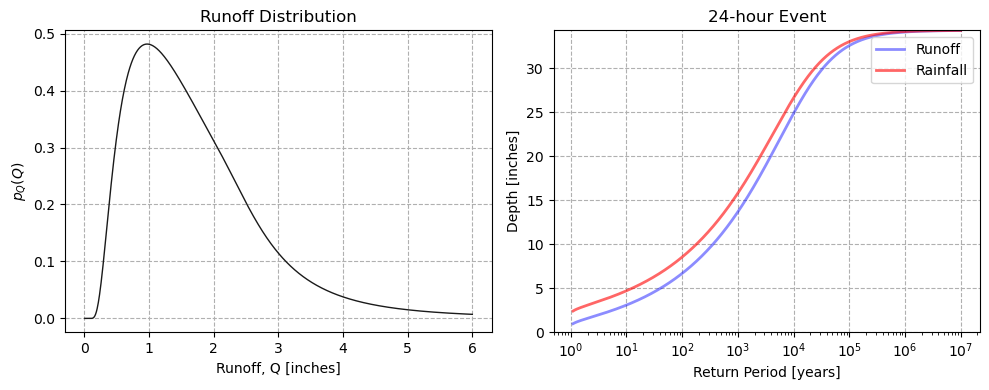

In [42]:
plot_runoff_distributions_final(GEV_parameters_E, GEV_parameters_R, PMP, fitted_cn, partition_avg, Delta_P, error_PQ)
plt.show()

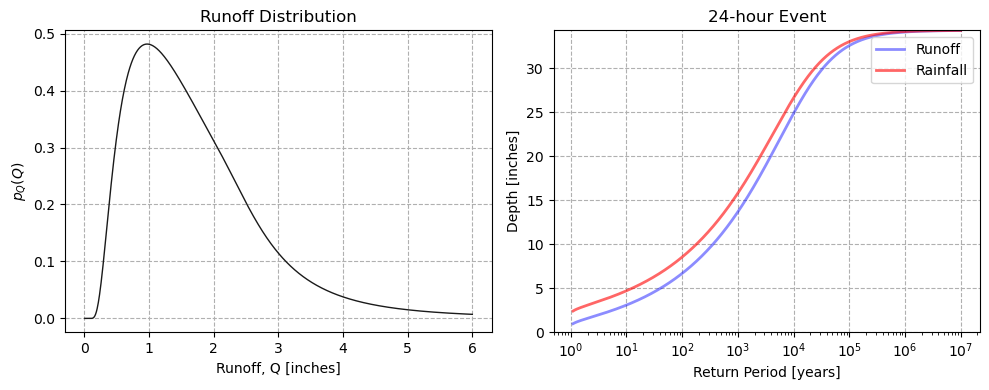

In [47]:
mu = fitted_cn.iloc[0]['mu']

Q1 = np.linspace(0.01, 6, 1000)
_, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].grid(linestyle='--')
ax[0].set_xlabel('Runoff, Q [inches]')
ax[0].set_ylabel('$p_Q(Q)$')
ax[0].set_title('Runoff Distribution')
ax[0].plot(Q1, PDF_Q(Q1, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, error_PQ), lw = 1, color = '0.1')

ax[1].set_xscale('log')
ax[1].grid(linestyle='--')
ax[1].set_ylim((0, PMP))
ax[1].set_xlabel('Return Period [years]')
ax[1].set_ylabel('Depth [inches]')
ax[1].set_title('24-hour Event') 

Return_Period = np.geomspace(1.1, 10**7, 100000)
Precip = GEV_RI(Return_Period, GEV_parameters_E, PMP)
Runoff = GEV_RI(Return_Period, GEV_parameters_R, PMP)

ax[1].plot(Return_Period, Runoff, 'b', lw=2, alpha=0.45, label = 'Runoff')
ax[1].plot(Return_Period, Precip, 'r', lw=2, alpha=0.6, label='Rainfall')

ax[1].legend()
plt.tight_layout()
plt.show()

#### Plot maximum potential distribution conditional on runoff:

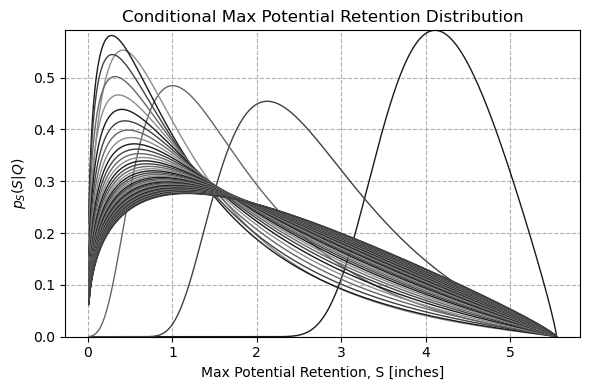

In [48]:
plot_max_potential_retention_cond_runoff(GEV_parameters_E, PMP, fitted_cn, partition_avg, Delta_P, error_PQ)
plt.show()

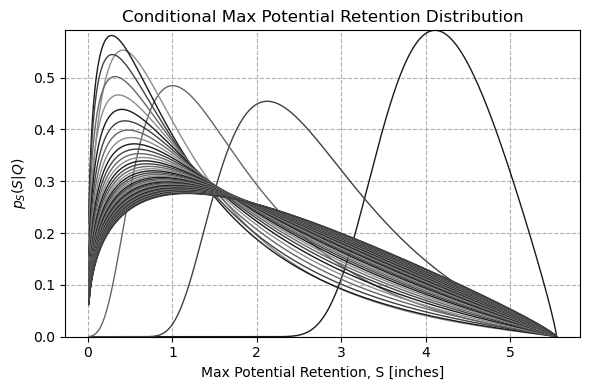

In [51]:
#def plot_max_potential_retention_cond_runoff(GEV_parameters_E: np.ndarray, PMP: float, fitted_cn: pd.DataFrame, 
                                            # partition_avg: np.ndarray, Delta_P: float, error_PQ: float) -> None:
"""Plots the distribution of the max potential retention conditional on different runoff values.
"""
custom_cycler = cycler('color', ['0.1', '0.25', '0.4', '0.55']) + cycler('lw', [1, 1, 1, 1])
S_limit = 1000.0/fitted_cn.iloc[0]['CN Lower Limit']-10
alpha = fitted_cn.iloc[0]['alpha']
beta = fitted_cn.iloc[0]['beta']
mu = fitted_cn.iloc[0]['mu']

S1 = np.linspace(0.01, S_limit, 1000)
QA = np.linspace(0.5, PMP, 50)
PDF_S = np.transpose([PDF_SlQ(S1, Q1, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha, beta, S_limit, 
                              error_PQ) for Q1 in QA])

_, ax = plt.subplots(1, 1, figsize=(6,4))
ax.set_prop_cycle(custom_cycler)
ax.plot(S1, PDF_S)
ax.grid(linestyle = '--')
ax.set_ylim((0, np.max(PDF_S)))
ax.set_xlabel('Max Potential Retention, S [inches]')
ax.set_ylabel('$p_S(S | Q)$')
ax.set_title('Conditional Max Potential Retention Distribution')
plt.tight_layout()
plt.show()

### Calculate Runoff and Corresponding Max Potential Retention and Rainfall:

In [61]:
df_runoff_SR1 = Scenarios_Avg_S_Median_S(df_weights_runoff, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha, beta, S_limit, error_PQ)
df_runoff_SR1.head(2)

,Bin Floor,Bin Ceiling,Event Weight,Runoff,Avg. S,Rainfall (Avg. S),Median S,Rainfall (Median S)
2,1.243898,4.119967,0.561204,1.571534,2.122458,3.198461,1.922913,3.078059
5,4.119967,6.220538,0.081963,2.373086,1.404366,3.644700,1.130767,3.435391


In [71]:
df_runoff_SR1

,Bin Floor,Bin Ceiling,Event Weight,Runoff,Avg. S,Rainfall (Avg. S),Median S,Rainfall (Median S)
2,1.243898,4.119967,0.561204,1.571534,2.122458,3.198461,1.922913,3.078059
5,4.119967,6.220538,0.081963,2.373086,1.404366,3.644700,1.130767,3.435391
10,6.220538,19.285480,0.108905,3.078335,1.315428,4.335702,1.003467,4.076107
25,19.285480,33.892991,0.022348,4.233783,1.422115,5.642018,1.109655,5.368554
50,33.892991,82.403766,0.017369,5.333347,1.532403,6.882628,1.235670,6.615348
100,82.403766,124.292811,0.004090,6.681513,1.639867,8.371648,1.361117,8.113532
200,124.292811,384.961487,0.005448,8.334513,1.738526,10.159056,1.480677,9.913782
500,384.961487,680.338394,0.001128,11.091334,1.853076,13.079208,1.620081,12.849889
1000,680.338394,1646.597548,0.000863,13.680225,1.927467,15.778695,1.710496,15.559987
2000,1646.597548,2493.087316,0.000206,16.725867,1.991232,18.922072,1.791934,18.716835


In [63]:
Runoff_Q = df_weights_runoff['Runoff'].values
Return_Intervals_Q = df_weights_runoff.index.values.astype(int)

#Calculating average S
Avg_S_list = [Avg_SlQ(Q1, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha, beta, S_limit, error_PQ, 0.0, 
                      S_limit) for Q1 in Runoff_Q]
R_Avg_S = [1.0/2.0*(Q+np.sqrt(Q)*np.sqrt(Q+4.0*S)+2.0*S*mu) for Q, S in zip(Runoff_Q, Avg_S_list)]

#Calculating median S
Median_S_list = [Median_S(Q1, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha, beta, S_limit, error_PQ, 
                          [(0.25, S_limit)], (0+S_limit)/3).x[0] for Q1 in Runoff_Q]
R_Median_S = [1.0/2.0*(Q+np.sqrt(Q)*np.sqrt(Q+4.0*S)+2.0*S*mu) for Q, S in zip(Runoff_Q, Median_S_list)]


new_data = np.vstack((Avg_S_list, R_Avg_S, Median_S_list, R_Median_S)).T
df_SR1 = pd.DataFrame(data=new_data, index=Return_Intervals_Q, 
                      columns=['Avg. S', 'Rainfall (Avg. S)', 'Median S', 'Rainfall (Median S)']) 


In [69]:
Runoff_Q

array([ 1.57153433,  2.37308628,  3.07833515,  4.23378337,  5.33334735,
        6.68151253,  8.33451328, 11.09133385, 13.68022547, 16.72586718,
       18.69668809, 24.36472089])

In [77]:
df_runoff_SR1

,Bin Floor,Bin Ceiling,Event Weight,Runoff,Avg. S,Rainfall (Avg. S),Median S,Rainfall (Median S)
2,1.243898,4.119967,0.561204,1.571534,2.122458,3.198461,1.922913,3.078059
5,4.119967,6.220538,0.081963,2.373086,1.404366,3.644700,1.130767,3.435391
10,6.220538,19.285480,0.108905,3.078335,1.315428,4.335702,1.003467,4.076107
25,19.285480,33.892991,0.022348,4.233783,1.422115,5.642018,1.109655,5.368554
50,33.892991,82.403766,0.017369,5.333347,1.532403,6.882628,1.235670,6.615348
100,82.403766,124.292811,0.004090,6.681513,1.639867,8.371648,1.361117,8.113532
200,124.292811,384.961487,0.005448,8.334513,1.738526,10.159056,1.480677,9.913782
500,384.961487,680.338394,0.001128,11.091334,1.853076,13.079208,1.620081,12.849889
1000,680.338394,1646.597548,0.000863,13.680225,1.927467,15.778695,1.710496,15.559987
2000,1646.597548,2493.087316,0.000206,16.725867,1.991232,18.922072,1.791934,18.716835


### Hydrology 3 Events:
- For each runoff value, two events are considered, a high max potential retention and a low max potential retention

In [62]:
df_runoff_SR2 = Scenarios_low_and_high_S(df_runoff_SR1, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha, beta, S_limit, error_PQ)
df_runoff_SR2.head(10)

,Event Weight,Runoff,Avg. S (Lower 50%),Rainfall (Lower 50%),Avg. S (Upper 50%),Rainfall (Upper 50%)
2,0.280602,1.571534,1.339505,2.703670,2.905412,3.643554
5,0.040981,2.373086,0.599304,2.988690,2.209427,4.207391
10,0.054453,3.078335,0.489427,3.605722,2.141429,4.960958
25,0.011174,4.233783,0.538357,4.824662,2.305874,6.352163
50,0.008685,5.333347,0.606564,6.004532,2.458242,7.655188
100,0.002045,6.681513,0.676688,7.436138,2.603046,9.204860
200,0.002724,8.334513,0.745970,9.172718,2.731082,11.048160
500,0.000564,11.091334,0.828396,12.031349,2.877756,14.037820
1000,0.000431,13.680225,0.882612,14.688759,2.972323,16.786004
2000,0.000103,16.725867,0.933315,17.798876,3.049148,19.969959


In [71]:
weights_runoff = df_runoff_SR1['Event Weight'].values
Runoff_Q = df_runoff_SR1['Runoff'].values
Return_Intervals_Q = df_runoff_SR1.index.values.astype(int)
Median_S_list = df_runoff_SR1['Median S'].values

# Calculating lower by integrating from 0 to S1 and, upper by integrating from S1 to S_limit
Avg_S_Lower50_list = [Avg_SlQ(Q1, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha, beta, S_limit, error_PQ, 
                              0.0, S1)/0.5 for Q1, S1 in zip(Runoff_Q, Median_S_list)]
Avg_S_Upper50_list = [Avg_SlQ(Q1, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha, beta, S_limit, error_PQ, 
                              S1, S_limit)/0.5 for Q1, S1 in zip(Runoff_Q, Median_S_list)]

# Calculating the runoff using the formula from doc file
R_Avg_S_Lower50 = [1.0/2.0*(Q+np.sqrt(Q)*np.sqrt(Q+4.0*S)+2.0*S*mu) for Q, S in zip(Runoff_Q, Avg_S_Lower50_list)]
R_Avg_S_Upper50 = [1.0/2.0*(Q+np.sqrt(Q)*np.sqrt(Q+4.0*S)+2.0*S*mu) for Q, S in zip(Runoff_Q, Avg_S_Upper50_list)]

new_data = np.vstack((weights_runoff*0.5, Runoff_Q, Avg_S_Lower50_list, R_Avg_S_Lower50, Avg_S_Upper50_list, 
                      R_Avg_S_Upper50)).T
df_SR2 = pd.DataFrame(data=new_data, index=Return_Intervals_Q,
                      columns=['Event Weight', 'Runoff', 'Avg. S (Lower 50%)', 'Rainfall (Lower 50%)', 
                               'Avg. S (Upper 50%)', 'Rainfall (Upper 50%)'])

In [73]:
Avg_S_Lower50_list

[1.3395047357756558,
 0.5993042259758244,
 0.4894266650842352,
 0.5383566955651218,
 0.6065640610158843,
 0.6766882100194591,
 0.7459703968582726,
 0.8283957519313755,
 0.8826122276822848,
 0.9333153555402803,
 0.9589211245674669,
 1.0132883990187675]

In [72]:
Avg_S_Upper50_list

[2.905411710569656,
 2.209427179839229,
 2.1414288487729167,
 2.305874034286918,
 2.4582416748009916,
 2.603045944533787,
 2.7310816992433353,
 2.8777564983088912,
 2.972322747331409,
 3.0491482153556855,
 3.088121190788254,
 3.1707553974439606]

In [72]:
#formatting
hydro_events_orig = list(df_runoff_SR2.index)
relabel_U = [str(hyetograph)+'_U' for hyetograph in hydro_events_orig]
relabel_L = [str(hyetograph)+'_L' for hyetograph in hydro_events_orig]

df_runoff_SR2_U = df_runoff_SR2[['Event Weight', 'Runoff', 'Avg. S (Upper 50%)', 'Rainfall (Upper 50%)']].copy()
df_runoff_SR2_U.rename(columns = {'Avg. S (Upper 50%)': 'Avg. S', 'Rainfall (Upper 50%)': 'Rainfall'}, inplace = True)
df_runoff_SR2_U.index = relabel_U

df_runoff_SR2_L = df_runoff_SR2[['Event Weight', 'Runoff', 'Avg. S (Lower 50%)',  'Rainfall (Lower 50%)']].copy()
df_runoff_SR2_L.rename(columns = {'Avg. S (Lower 50%)': 'Avg. S', 'Rainfall (Lower 50%)': 'Rainfall'}, inplace = True)
df_runoff_SR2_L.index = relabel_L

#df_weights_rainfall = df_runoff_SR2_U.append(df_runoff_SR2_L).sort_values(by=['Runoff'])
df_weights_rainfall = pd.concat([df_runoff_SR2_U, df_runoff_SR2_L]).sort_values(by=['Runoff'])
df_weights_rainfall.head(2)

,Event Weight,Runoff,Avg. S,Rainfall
2_U,0.280602,1.571534,2.905412,3.643554
2_L,0.280602,1.571534,1.339505,2.703670


In [73]:
df_weights_rainfall

,Event Weight,Runoff,Avg. S,Rainfall
2_U,0.280602,1.571534,2.905412,3.643554
2_L,0.280602,1.571534,1.339505,2.703670
5_U,0.040981,2.373086,2.209427,4.207391
5_L,0.040981,2.373086,0.599304,2.988690
10_U,0.054453,3.078335,2.141429,4.960958
10_L,0.054453,3.078335,0.489427,3.605722
25_U,0.011174,4.233783,2.305874,6.352163
25_L,0.011174,4.233783,0.538357,4.824662
50_U,0.008685,5.333347,2.458242,7.655188
50_L,0.008685,5.333347,0.606564,6.004532


#### Hydrology 3 Runoff Forcing Data:

In [75]:
#events and excess precip curves
RI_list = np.sort(np.concatenate((df_runoff_SR2.index.to_numpy(), df_runoff_SR2.index.to_numpy())))
prep_curves = precip_to_runoff_h3(RI_list,nrcs_precip_table_dir, df_weights_rainfall,df_weights_rainfall)
final_curves = extend_time(prep_curves,Time_Extend,0.1)

In [76]:
#def precip_to_runoff_h3(hydro_events:np.ndarray ,nrcs_precip_table_dir: pl.WindowsPath,
                     #precip_data: pd.DataFrame,df_weights_rainfall: pd.DataFrame, display_print = False) -> pd.DataFrame:

hyeto_graphs = np.where(RI_list <1000, RI_list, 1000).astype(int).tolist()
hydro_events = list(df_weights_rainfall.index)
prep_curves = pd.DataFrame(columns = hydro_events)
for event, hyetograph in zip(hydro_events, hyeto_graphs):
    dist_df = get_hyeto_input_data_nrcs(nrcs_precip_table_dir, hyetograph, display_print)
    dist_df['precip'] = dist_df['ratio']*df_weights_rainfall['Rainfall'].loc[event]
    s = df_weights_rainfall['Avg. S'].loc[event]
    ia = IA_24hr(s)
    dist_df1 = excess_precip(dist_df,ia, s)
    prep_curves[event] = dist_df['hyeto_input']

In [94]:
dist_df1

,ratio,slope,t_step,precip,excess_precip,hyeto_input
time,,,,,,
0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
0.1,0.003157,0.003157,0.1,0.080638,0.000000,0.000000
0.2,0.005042,0.001884,0.2,0.128771,0.000000,0.000000
0.3,0.007005,0.001963,0.3,0.178913,0.000000,0.000000
0.4,0.009052,0.002048,0.4,0.231212,0.000783,0.000783
...,...,...,...,...,...,...
11.6,0.992708,0.001884,11.6,25.355443,24.178737,0.048056
11.7,0.994567,0.001859,11.7,25.402932,24.226155,0.047418
11.8,0.996402,0.001835,11.8,25.449796,24.272949,0.046794


In [77]:
np.sum(dist_df1['hyeto_input'])

24.36472089372656

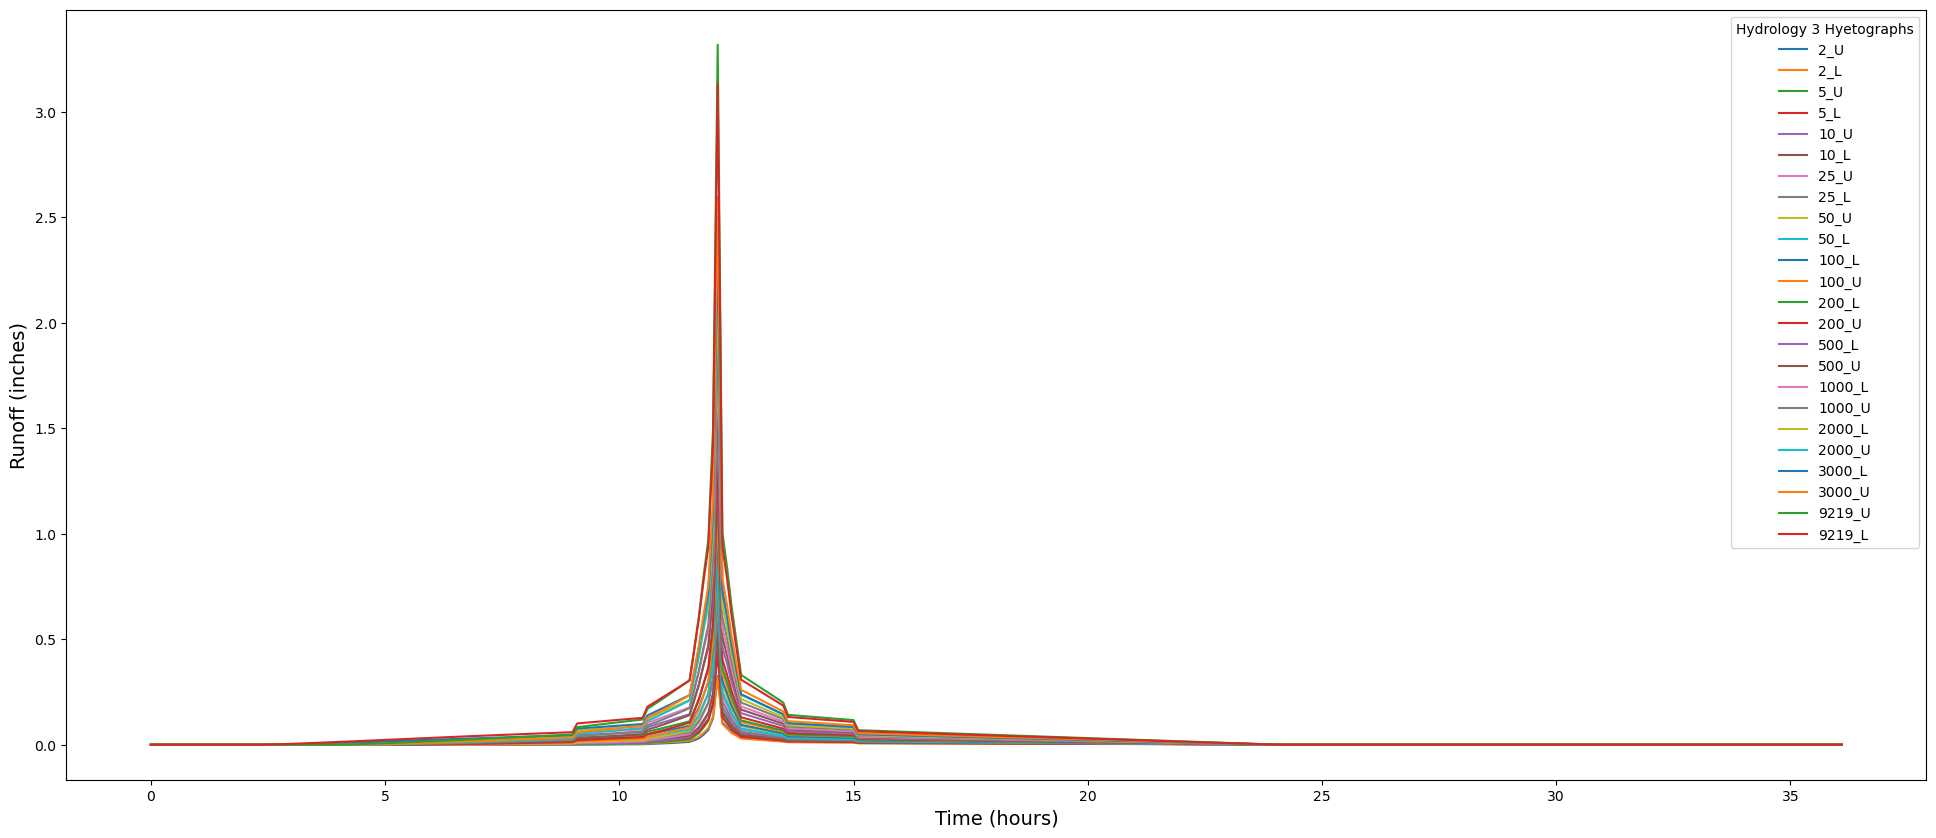

In [40]:
## graph
t_p = final_curves.plot(figsize=(24,10))
t_p.legend(title='Hydrology 3 Hyetographs')
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Runoff (inches)',fontsize=14)
t_p.plot();
plt.show()

#### Hydrology 3 Weights:

In [41]:
#formatting
Event_Weights_Hydro = df_weights_rainfall['Event Weight'].apply(lambda x: '%.20f' % x).to_dict()

ID_Hydrology = 3
rename_map = Rename_Final_Events_Precip_Stratified(Event_Weights_Hydro, ID_Hydrology) #set naming convention
renamed_weights = {}

for k, v in rename_map.items():
    renamed_weights[v] = Event_Weights_Hydro [k]

renamed_weights

{'E3001': '0.27809739478111972222',
 'E3002': '0.27809739478111972222',
 'E3003': '0.04155989358014533508',
 'E3004': '0.04155989358014533508',
 'E3005': '0.05415423972301317695',
 'E3006': '0.05415423972301317695',
 'E3007': '0.01123601265352035597',
 'E3008': '0.01123601265352035597',
 'E3009': '0.00864081090512738154',
 'E3010': '0.00864081090512738154',
 'E3011': '0.00206104149057252661',
 'E3012': '0.00206104149057252661',
 'E3013': '0.00271574228216445689',
 'E3014': '0.00271574228216445689',
 'E3015': '0.00056387954353896100',
 'E3016': '0.00056387954353896100',
 'E3017': '0.00043119230695959370',
 'E3018': '0.00043119230695959370',
 'E3019': '0.00010278139841164068',
 'E3020': '0.00010278139841164068',
 'E3021': '0.00006554841519755889',
 'E3022': '0.00006554841519755889',
 'E3023': '0.00013513513513513514',
 'E3024': '0.00013513513513513514'}

In [42]:
renamed_curves = final_curves.rename(columns=rename_map).copy()

renamed_curves.index = renamed_curves.index.to_series().apply(lambda x: '%.1f' % x)
renamed_curves.head(10)

,E3001,E3002,E3003,E3004,E3005,E3006,E3007,E3008,E3009,E3010,...,E3015,E3016,E3017,E3018,E3019,E3020,E3021,E3022,E3023,E3024
hours,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
## Convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight': list(renamed_weights.values())}, index = list(renamed_weights.keys())) 
df_renamed_weights.head(2)

,Weight
E3001,0.27809739478111972222
E3002,0.27809739478111972222


### Save

##### To CSV:

In [44]:
renamed_curves.to_csv(outputs_dir/'Excess_Rainfall_{0}_Dur{1}_Hydro{2}.csv'.format(BCN, duration,ID_Hydrology))
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_Hydro{2}.csv'.format(BCN, duration, ID_Hydrology))

In [45]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_Hydro{3}.xlsx'.format(Project_Area, Pluvial_Model, BCN, ID_Hydrology))

for i, d in enumerate(rename_map.keys()):
    table = renamed_curves[rename_map[d]]
    table.to_excel(writer, sheet_name = 'ras_input_{0}-{1}'.format(d,rename_map[d]))
 
writer.close()

---
## Hydrology 4
*Events are the same as Hydrology 3*

#### Hydrology 4 Runoff Forcing Data:

In [94]:
prep_curves

,2_U_q1,2_U_q2,2_U_q3,2_U_q4,2_L_q1,2_L_q2,2_L_q3,2_L_q4,5_U_q1,5_U_q2,...,3000_U_q3,3000_U_q4,9219_U_q1,9219_U_q2,9219_U_q3,9219_U_q4,9219_L_q1,9219_L_q2,9219_L_q3,9219_L_q4
hours,,,,,,,,,,,,,,,,,,,,,
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.5,0.058495,0.000000,0.000000,0.000000,0.143289,0.000000,0.000000,0.000000,0.180405,0.000000,...,0.000000,0.000000,4.126535,0.065373,0.000000,0.000000,5.206898,0.372421,0.000000,0.000000
1.0,0.325804,0.000000,0.000000,0.000000,0.378598,0.002323,0.000000,0.000000,0.542299,0.000506,...,0.000000,0.000000,5.105316,0.824283,0.000000,0.000000,4.970156,1.294250,0.000282,0.004136
1.5,0.372792,0.001155,0.000000,0.000000,0.365073,0.029948,0.000000,0.000000,0.539822,0.032467,...,0.000000,0.000000,4.140959,1.071408,0.000000,0.000000,3.905566,1.264590,0.008562,0.023365
2.0,0.325695,0.012910,0.000000,0.000000,0.298587,0.036201,0.000000,0.000000,0.447128,0.046298,...,0.000000,0.000000,3.171234,0.819195,0.000000,0.000000,2.960852,0.886730,0.004181,0.031448
2.5,0.256344,0.013332,0.000000,0.000000,0.227245,0.025472,0.000000,0.000000,0.342489,0.033882,...,0.000000,0.000000,2.337053,0.492257,0.000000,0.000000,2.172169,0.515358,0.003740,0.028745
3.0,0.188518,0.009429,0.000000,0.000000,0.163960,0.015959,0.000000,0.000000,0.248010,0.021558,...,0.000000,0.000000,1.656570,0.287842,0.000000,0.000115,1.536066,0.296960,0.011438,0.024180
3.5,0.131097,0.009388,0.000000,0.000000,0.112732,0.014909,0.000000,0.000000,0.170888,0.020318,...,0.000000,0.000000,1.127265,0.258118,0.000000,0.001090,1.043873,0.263996,0.026079,0.019761
4.0,0.086752,0.015802,0.000000,0.000000,0.074089,0.023603,0.000000,0.000000,0.112456,0.032452,...,0.000000,0.000000,0.736300,0.391512,0.000000,0.001706,0.681300,0.396852,0.040106,0.016836


In [78]:
#events and excess precip curves
RI_list = np.sort(np.concatenate((df_runoff_SR2.index.to_numpy(), df_runoff_SR2.index.to_numpy())))
prep_curves, prep_weights = precip_to_runoff_h4(RI_list,atlas14_precip_table_dir,
                     df_weights_rainfall,df_weights_rainfall)
final_curves = extend_time(prep_curves,Time_Extend,0.5)

C:\Users\dneupane\Documents\pfra-try\notebooks\pluvial\../../core\hydromet_stratified.py:827: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


C:\Users\dneupane\Documents\pfra-try\notebooks\pluvial\../../core\hydromet_stratified.py:827: FutureW

In [79]:
final_curves

,2_U_q1,2_U_q2,2_U_q3,2_U_q4,2_L_q1,2_L_q2,2_L_q3,2_L_q4,5_U_q1,5_U_q2,...,3000_U_q3,3000_U_q4,9026_U_q1,9026_U_q2,9026_U_q3,9026_U_q4,9026_L_q1,9026_L_q2,9026_L_q3,9026_L_q4
hours,,,,,,,,,,,,,,,,,,,,,
0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
0.5,0.036934,0.000000,0.0,0.0,0.100446,0.000000,0.0,0.0,0.139512,0.000000,...,0.0,0.0,4.327425,0.072837,0.0,0.0,5.427362,0.391117,0.000000,0.000000
1.0,0.261737,0.000000,0.0,0.0,0.309724,0.000141,0.0,0.0,0.461245,0.000000,...,0.0,0.0,5.312745,0.872034,0.0,0.0,5.172399,1.350099,0.000370,0.004603
1.5,0.314078,0.000000,0.0,0.0,0.310224,0.017389,0.0,0.0,0.469819,0.021240,...,0.0,0.0,4.303747,1.122657,0.0,0.0,4.064016,1.317168,0.009282,0.024856
2.0,0.279085,0.006015,0.0,0.0,0.257586,0.025826,0.0,0.0,0.392698,0.035971,...,0.0,0.0,3.294493,0.855834,0.0,0.0,3.080869,0.923219,0.004456,0.033178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22.5,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
23.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
23.5,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000


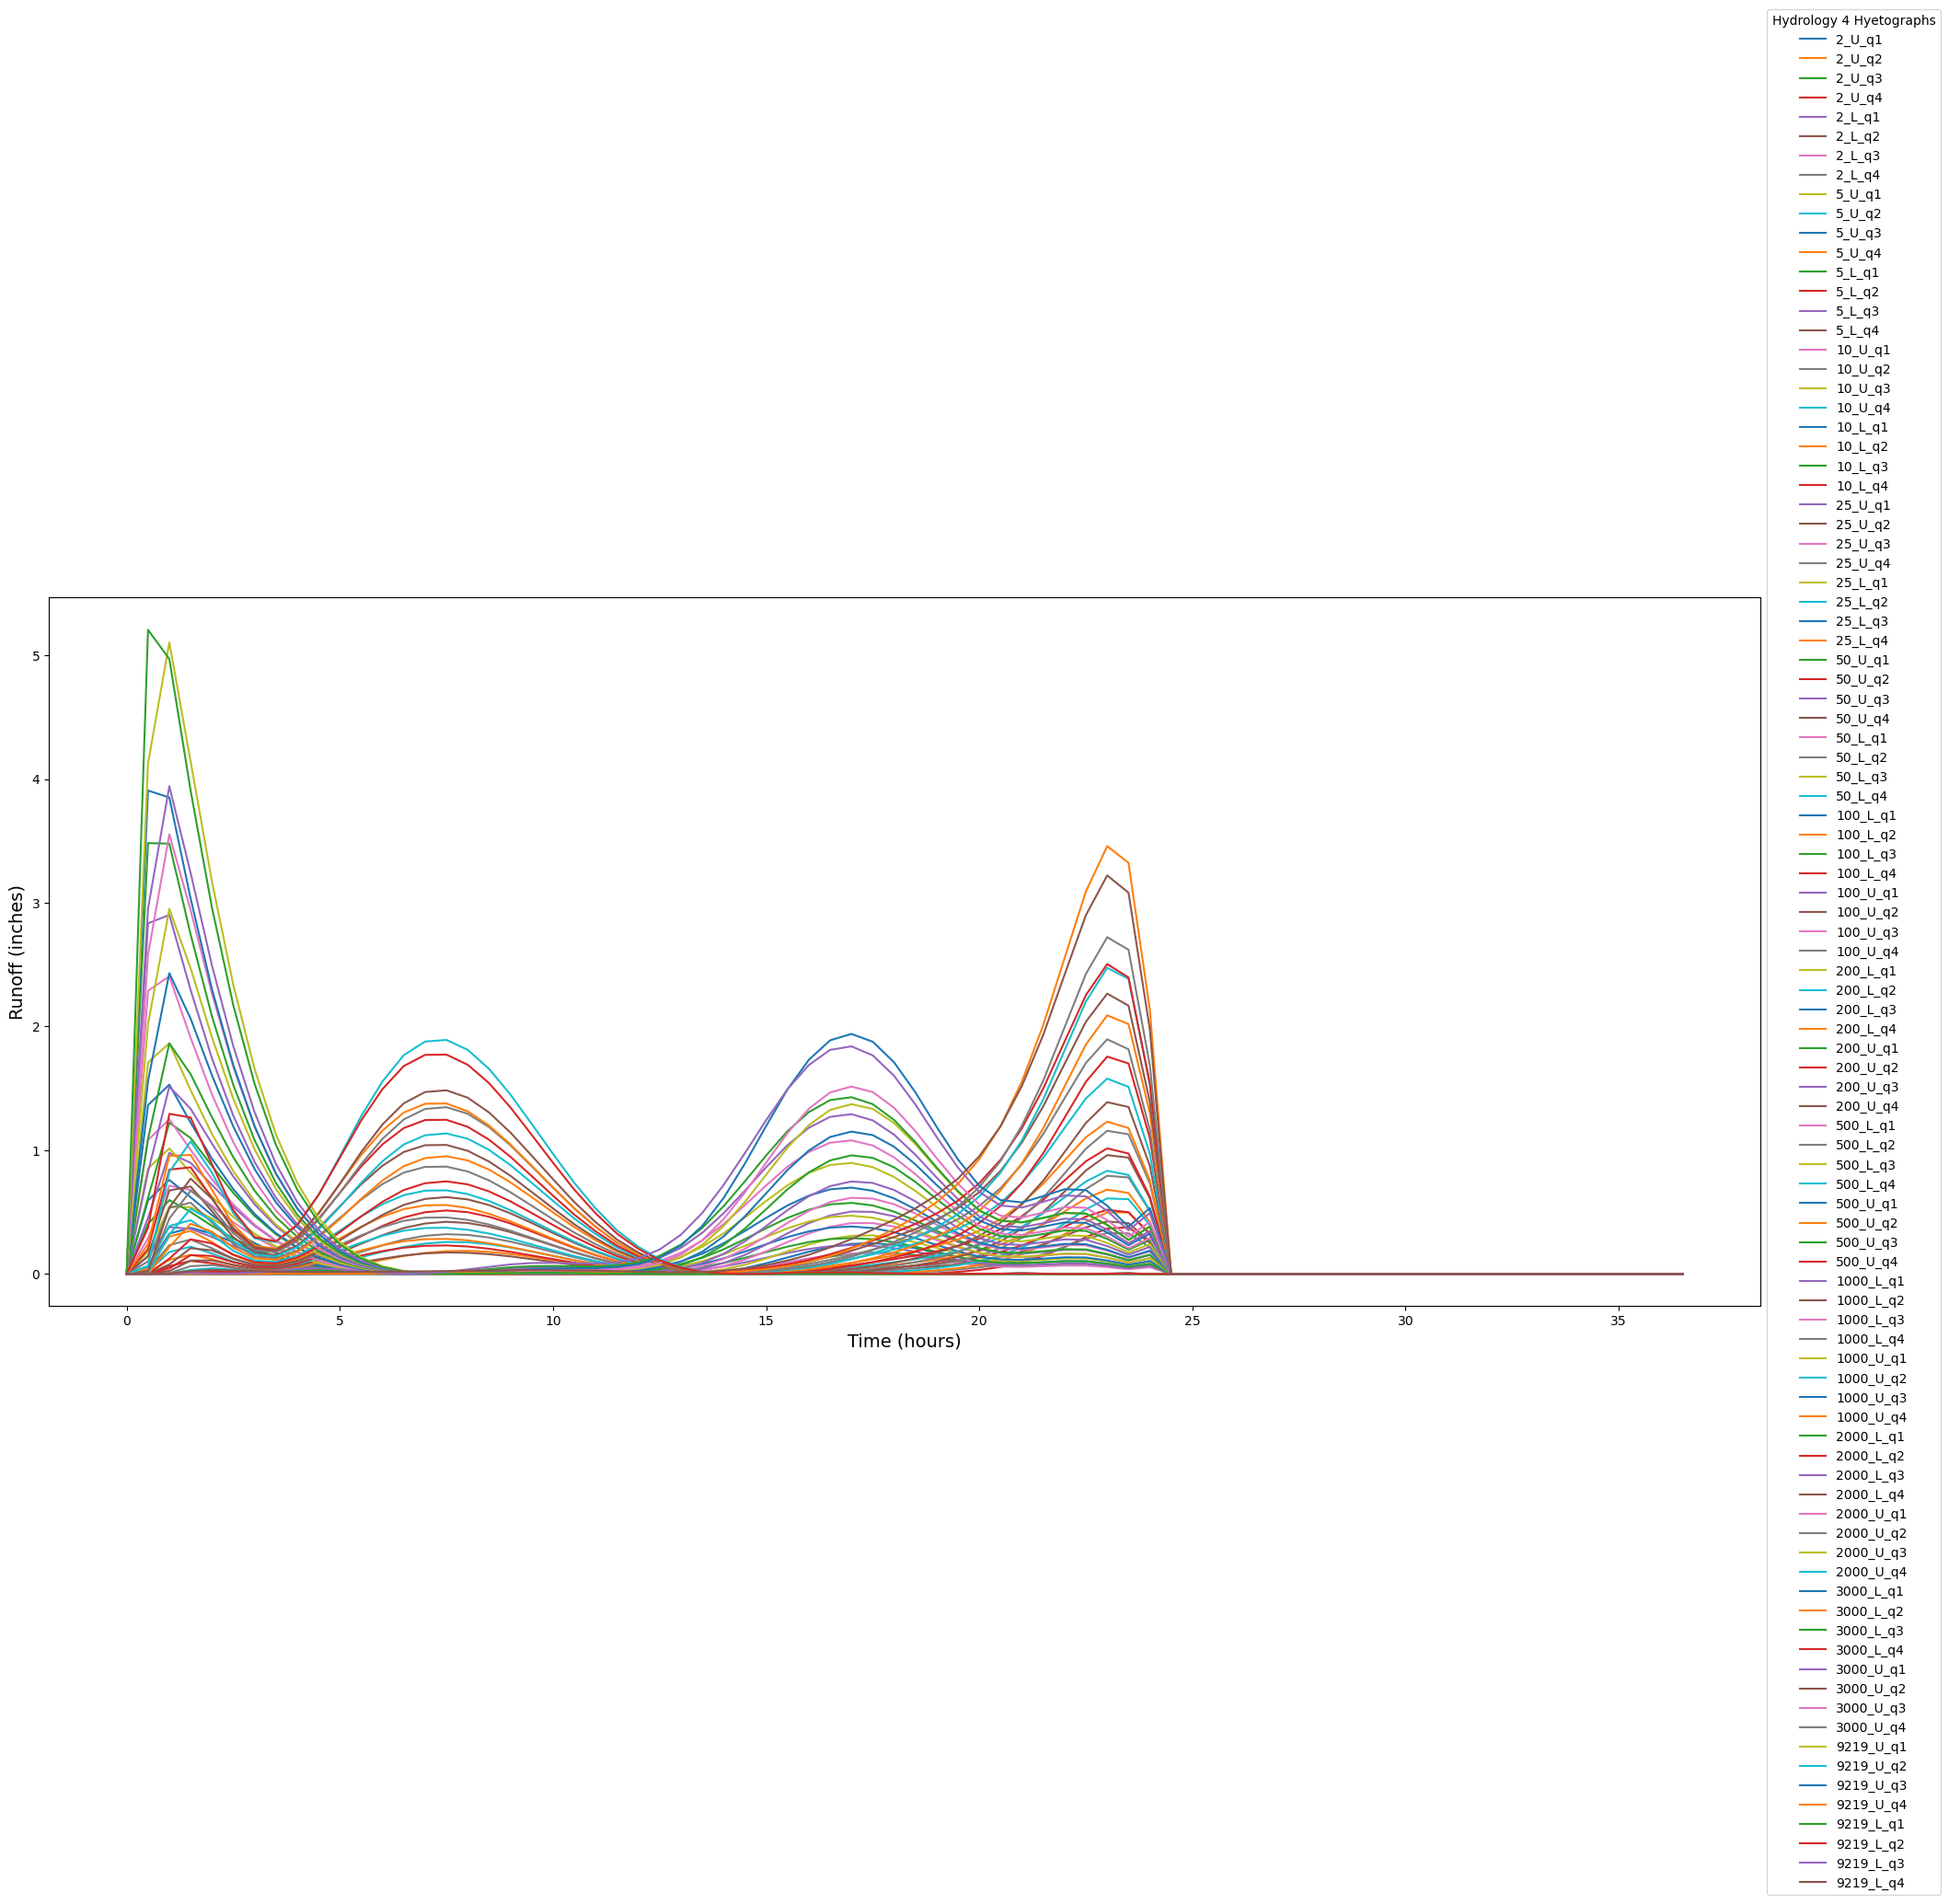

In [47]:
## graph
t_p = final_curves.plot(figsize=(24,10))
t_p.legend(title='Hydrology 4 Hyetographs',loc='center left', bbox_to_anchor=(1.0, 0.5))
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Runoff (inches)', fontsize=14)
t_p.plot();
plt.show()

#### Hydrology 4 Weights:

In [48]:
Event_Weights_Hydro = prep_weights['Event Weight'].apply(lambda x: '%.20f' % x).to_dict()

ID_Hydrology = 4
rename_map = Rename_Final_Events_Precip_Stratified(Event_Weights_Hydro, ID_Hydrology) #set naming convention
renamed_weights = {}

for k, v in rename_map.items():
    renamed_weights[v] = Event_Weights_Hydro[k]
    
renamed_weights

{'E4001': '0.14461064528618225444',
 'E4002': '0.05005753106060154695',
 'E4003': '0.04727655711279035722',
 'E4004': '0.03615266132154556361',
 'E4005': '0.14461064528618225444',
 'E4006': '0.05005753106060154695',
 'E4007': '0.04727655711279035722',
 'E4008': '0.03615266132154556361',
 'E4009': '0.02161114466167557424',
 'E4010': '0.00748078084442616031',
 'E4011': '0.00706518190862470783',
 'E4012': '0.00540278616541889356',
 'E4013': '0.02161114466167557424',
 'E4014': '0.00748078084442616031',
 'E4015': '0.00706518190862470783',
 'E4016': '0.00540278616541889356',
 'E4017': '0.02816020465596685146',
 'E4018': '0.00974776315014237206',
 'E4019': '0.00920622075291224057',
 'E4020': '0.00704005116399171287',
 'E4021': '0.02816020465596685146',
 'E4022': '0.00974776315014237206',
 'E4023': '0.00920622075291224057',
 'E4024': '0.00704005116399171287',
 'E4025': '0.00584272657983058493',
 'E4026': '0.00202248227763366381',
 'E4027': '0.00191012215109846056',
 'E4028': '0.001460681644957

In [49]:
#formatting
renamed_curves = final_curves.rename(columns=rename_map).copy()
renamed_curves.index = renamed_curves.index.to_series().apply(lambda x: '%.1f' % x)
renamed_curves.head(10)

,E4001,E4002,E4003,E4004,E4005,E4006,E4007,E4008,E4009,E4010,...,E4087,E4088,E4089,E4090,E4091,E4092,E4093,E4094,E4095,E4096
hours,,,,,,,,,,,,,,,,,,,,,
0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.5,0.058495,0.000000,0.0,0.0,0.143289,0.000000,0.0,0.0,0.180405,0.000000,...,0.0,0.0,4.126535,0.065373,0.000000,0.000000,5.206898,0.372421,0.000000,0.000000
1.0,0.325804,0.000000,0.0,0.0,0.378598,0.002323,0.0,0.0,0.542299,0.000506,...,0.0,0.0,5.105316,0.824283,0.000000,0.000000,4.970156,1.294250,0.000282,0.004136
1.5,0.372792,0.001155,0.0,0.0,0.365073,0.029948,0.0,0.0,0.539822,0.032467,...,0.0,0.0,4.140959,1.071408,0.000000,0.000000,3.905566,1.264590,0.008562,0.023365
2.0,0.325695,0.012910,0.0,0.0,0.298587,0.036201,0.0,0.0,0.447128,0.046298,...,0.0,0.0,3.171234,0.819195,0.000000,0.000000,2.960852,0.886730,0.004181,0.031448
2.5,0.256344,0.013332,0.0,0.0,0.227245,0.025472,0.0,0.0,0.342489,0.033882,...,0.0,0.0,2.337053,0.492257,0.000000,0.000000,2.172169,0.515358,0.003740,0.028745
3.0,0.188518,0.009429,0.0,0.0,0.163960,0.015959,0.0,0.0,0.248010,0.021558,...,0.0,0.0,1.656570,0.287842,0.000000,0.000115,1.536066,0.296960,0.011438,0.024180
3.5,0.131097,0.009388,0.0,0.0,0.112732,0.014909,0.0,0.0,0.170888,0.020318,...,0.0,0.0,1.127265,0.258118,0.000000,0.001090,1.043873,0.263996,0.026079,0.019761
4.0,0.086752,0.015802,0.0,0.0,0.074089,0.023603,0.0,0.0,0.112456,0.032452,...,0.0,0.0,0.736300,0.391512,0.000000,0.001706,0.681300,0.396852,0.040106,0.016836


In [50]:
## Convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight': list(renamed_weights.values())}, index = list(renamed_weights.keys())) 
df_renamed_weights.head(96)

,Weight
E4001,0.14461064528618225444
E4002,0.05005753106060154695
E4003,0.04727655711279035722
E4004,0.03615266132154556361
E4005,0.14461064528618225444
...,...
E4092,0.00001756756756756757
E4093,0.00007027027027027028
E4094,0.00002432432432432432
E4095,0.00002297297297297298


### Save

##### To CSV:

In [51]:
renamed_curves.to_csv(outputs_dir/'Excess_Rainfall_{0}_Dur{1}_Hydro{2}.csv'.format(BCN, duration,ID_Hydrology))
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_Hydro{2}.csv'.format(BCN, duration, ID_Hydrology))

In [52]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_Hydro{3}.xlsx'.format(Project_Area, Pluvial_Model, BCN, ID_Hydrology))

for i, d in enumerate(rename_map.keys()):
    table = renamed_curves[rename_map[d]]
    table.to_excel(writer, sheet_name = 'ras_input_{0}-{1}'.format(d,rename_map[d]))
 
writer.close()

## Save Hydrology 1-4 Outputs to JSON and DSS

### Runoff Forcing Data

In [53]:
excess_dic = combine_results_stratified('Excess_Rainfall', outputs_dir, BCN, duration, hydrology_IDs, run_dur_dic, remove_ind_dur)

with open(outputs_dir/'{0}_{1}_{2}.json'.format(Project_Area, Pluvial_Model, BCN), 'w') as f:
    json.dump(excess_dic, f)
    
forcing = '{0}_{1}_{2}'.format(Project_Area, Pluvial_Model, BCN)
jsonname = '{0}_{1}_{2}.json'.format(Project_Area, Pluvial_Model, BCN)
hydromet_JSON_to_DSS.main(outputs_dir, outputs_dir, bin_dir, forcing, jsonname, scaling = True, remove_temp_files = True, display_print = True)


Converting JoCo_P01_TurkeyCreek.json to DSS...
Dss File written to C:\Users\dneupane\Documents\pfra-hydromet\notebooks\pluvial\Outputs\JoCo_P01_TurkeyCreek_H01.dss
Dss File written to C:\Users\dneupane\Documents\pfra-hydromet\notebooks\pluvial\Outputs\JoCo_P01_TurkeyCreek_H02.dss
Dss File written to C:\Users\dneupane\Documents\pfra-hydromet\notebooks\pluvial\Outputs\JoCo_P01_TurkeyCreek_H03.dss
Dss File written to C:\Users\dneupane\Documents\pfra-hydromet\notebooks\pluvial\Outputs\JoCo_P01_TurkeyCreek_H04.dss


### Weights

In [54]:
weights_dic = combine_results_stratified('Weights',  outputs_dir, BCN, duration, hydrology_IDs, run_dur_dic, remove_ind_dur)

with open(outputs_dir/'{0}_{1}_{2}_Weights.json'.format(Project_Area, Pluvial_Model, BCN), 'w') as f:
    json.dump(weights_dic, f)

---
# End